In [1]:
import math
import datetime as dt

import xarray as xr
#Load netCDF
from netCDF4 import Dataset

from tqdm import tqdm_notebook as tqdm
from functools import partial

import numpy as np
from numpy.linalg import inv

import scipy as sp
from scipy import sparse
from scipy.sparse.linalg import inv as spinv
import scipy.stats as stats

import pandas as pd

from os import remove, listdir
from os.path import isfile, join

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy

import sys
sys.path.append('/Users/hannahnesser/Documents/Harvard/Research/Python')
import inv_plot
import clusters
import jacobian
import inv_rr

colors = plt.cm.get_cmap('inferno', lut=8)
c2 = plt.cm.get_cmap('inferno', lut=9)

rcParams['font.family'] = 'serif'
rcParams['font.size'] = 14

%matplotlib inline

# Clusters

In [2]:
# Import clusters
clusters_1x125 = clusters.open_clusters('Jacobian_Construction/Clusters_NA_1x125.nc')
clusters_2x25 = clusters.open_clusters('Jacobian_Construction/Clusters_NA_2x25.nc')

# Oops changed my mind actually we're keeping all observations at least for a bit
# # Import delta_obs so that we can use it to eliminate the observations we aren't 
# # interested in.
# delta_obs_loc = 'Input/delta_obs.csv'
# delta_obs = jacobian.get_delta_obs(delta_obs_loc)

# We only want to work in the domain where we have full clusters 
# at both resolutions
clusters_1x125_s, clusters_2x25_s = clusters.reduce_SV_elements(clusters_1x125,
                                                                clusters_2x25)

# Create reduced clusters (i.e. our actual grid) for plotting purposes
clusters_1x125_r = clusters.reduced_clusters(clusters_1x125_s)

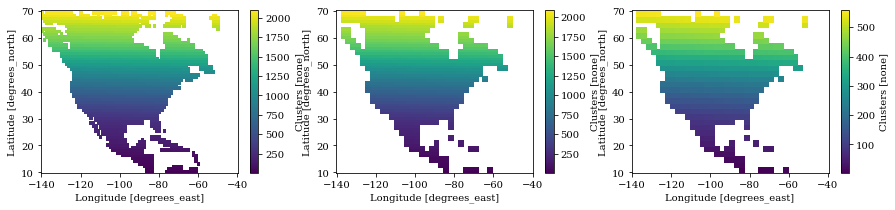

In [3]:
fig, ax = plt.subplots(1,3,figsize=(15,3))
clusters_1x125.where(clusters_1x125 > 0).plot(ax=ax[0])
clusters_1x125_s.where(clusters_1x125_s > 0).plot(ax=ax[1])
clusters_2x25_s.where(clusters_2x25_s > 0).plot(ax=ax[2])

In [4]:
# Check the work
n_clust_1x125 = len(np.unique(clusters_1x125_s))-1
n_clust_2x25 = len(np.unique(clusters_2x25_s))-1

print('Number of 1x1.25 Clusters:                  %d' % n_clust_1x125)
print('Number of 2x2.5 Clusters:                   %d' % n_clust_2x25)
print('Ratio of 2x2.5 Clusters to 1x1.25 Clusters: %.1f' % (n_clust_1x125/n_clust_2x25))
# print('Shape of delta_obs:                         %s' % str(delta_obs.shape))

Number of 1x1.25 Clusters:                  1800
Number of 2x2.5 Clusters:                   450
Ratio of 2x2.5 Clusters to 1x1.25 Clusters: 4.0


# Build a Prior-Based Jacobian

In [5]:
emis_loc = 'Perturbation_Runs/base_emis.nc'
# emis_loc = 'Base_Run'
emis = jacobian.get_delta_emis(clusters_long=clusters_1x125_s,
                               emis_loc=emis_loc)
# y, y_base = jacobian.get_obs('Base_Run/sat_obs.gosat.00.m', delta_obs)
y_full = pd.read_csv('Base_Run/sat_obs.gosat.00.m', 
                          delim_whitespace=True,
                          header=0)
y_full['GOSAT'] *= 1e9
y_full['model'] *= 1e9
y_full = y_full[y_full['GLINT'] == False]

y_full = y_full[['NNN', 'LON', 'LAT', 'GOSAT', 'model']]
y_full = y_full.rename(columns={'LON' : 'lon', 
                                'LAT' : 'lat',
                                'NNN' : 'Nobs'})

# Assign the change in emissions to the appropriate observations
cs = clusters_1x125_r#.to_dataframe().reset_index()

lat_width = np.diff(cs.coords['lat'].values)[0]/2
lat_edges = cs.coords['lat'].values - lat_width
lat_edges = np.append(lat_edges, cs.coords['lat'].values[-1]+lat_width)
y_full['lat_bin'] = pd.cut(y_full['lat'], 
                                bins=lat_edges, 
                                labels=cs.coords['lat'].values)
y_full['lat_bin'] = y_full['lat_bin'].astype(float)

lon_width = np.diff(cs.coords['lon'].values)[0]/2
lon_edges = cs.coords['lon'].values - lon_width
lon_edges = np.append(lon_edges, cs.coords['lon'].values[-1]+lon_width)
y_full['lon_bin'] = pd.cut(y_full['lon'], 
                                bins=lon_edges, 
                                labels=cs.coords['lon'].values)
y_full['lon_bin'] = y_full['lon_bin'].astype(float)

y_full = y_full.rename(columns={'lon' : 'lon_true',
                                'lat' : 'lat_true',
                                'lon_bin' : 'lon',
                                'lat_bin' : 'lat'})

cs_df = cs.to_dataframe('Clusters').reset_index()
y_full = y_full.merge(cs_df, on=['lat', 'lon'], how='left')
y_full = y_full.rename(columns={'Clusters' : 'NSV'})
y_full = y_full.sort_values(by='Nobs');

/anaconda3/lib/python3.6/site-packages/xarray/core/groupby.py:749: FutureWarning: Default reduction dimension will be changed to the grouped dimension after xarray 0.12. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  allow_lazy=True, **kwargs)


In [6]:
# # Calculate the change above each grid cell
# get moles air
emis_loc = 'Base_Run/HEMCO_diagnostics.200907010000.nc'
emis_pert = xr.open_dataset(emis_loc)
emis_pert = emis_pert.where(emis_pert.lev == emis_pert.lev.min(), drop=True)
emis_pert = emis_pert.drop(['time', 'lev', 'hyam', 'hybm', 'P0'])
emis_pert = emis_pert.squeeze(['time', 'lev'])
emis_pert['EmisCH4_Total'] = emis_pert['EmisCH4_Total'] - emis_pert['EmisCH4_SoilAbsorb']

# Units are originally in kg/m2/s. Change it to mole/s. (Normally we do per month
# but we are converting to observations...)
emis_pert['EmisCH4_Total'] = 0.5*emis_pert['EmisCH4_Total']*emis_pert['AREA']/0.016
# emis_pert['EmisCH4_Total'] = emis_pert['EmisCH4_Total']*emis_pert['AREA']*(60*60*24*31)*1e3

# Okay... now we convert to moles (moles/second)... and make it a perturbation 
# (multiply by 1/2)
# emis_pert['mol_CH4'] = 0.5*emis_pert['EmisCH4_Total']/0.016

# Group by NSV
emis_pert['NSV'] = clusters_1x125_s
emis_pert = emis_pert.groupby('NSV').sum()[['EmisCH4_Total', 'AREA']]
emis_pert = emis_pert.where(emis_pert['NSV'] > 0, drop=True)

# And estimate the number of moles of air
# emis_pert['mol_air_est'] = emis_pert['AREA']*(100000/9.8)/(0.02897)

# Calculate ppb using Daniel's equation...
Mair = 0.02897 #kg/mol
P = 100000 # Pa
g = 9.8 # m/s^2
U = 5*(1000/3600) # 5 km/hr in m/s
W = emis_pert['AREA']**0.5 # m
emis_pert['ppbv_CH4'] = 1e9*Mair*emis_pert['EmisCH4_Total']*g/(U*W*P)

# # And plot
# plot_options_pert = {'cmap' : inv_plot.cm_transparent_at_zero('viridis'),
#                      'vmin' : 0,
#                      'vmax' : 10,
# #                      'vmax' : 5e-10,
#                      'add_colorbar' : True,
#                      'cbar_kwargs' : {'label' : 'ppbv'}}
# ax = inv_plot.plot_state(emis_pert['ppbv_CH4'], 
#                          clusters=clusters_1x125_r, 
#                          **plot_options_pert)

/anaconda3/lib/python3.6/site-packages/xarray/core/groupby.py:749: FutureWarning: Default reduction dimension will be changed to the grouped dimension after xarray 0.12. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  allow_lazy=True, **kwargs)


In [7]:
c = clusters_1x125_r.stack(NSV=['lat', 'lon'])
c = c.where(c > 0, drop=True)
c = c.reset_index(['NSV', 'lat', 'lon'])
c['NSV'] = c.values
c = c.coords.to_dataset()
emis_pert = c.merge(emis_pert)
emis_pert

<xarray.Dataset>
Dimensions:        (NSV: 1800)
Coordinates:
    lat            (NSV) float64 10.25 10.25 10.25 10.25 ... 69.25 69.25 69.25
    lon            (NSV) float64 -84.69 -83.44 -74.69 ... -105.9 -97.19 -95.94
  * NSV            (NSV) float64 2.0 3.0 5.0 ... 2.083e+03 2.088e+03 2.089e+03
Data variables:
    EmisCH4_Total  (NSV) float64 87.83 183.0 78.65 49.34 ... 0.5353 1.472 0.2467
    AREA           (NSV) float64 1.523e+10 1.523e+10 ... 5.483e+09 5.483e+09
    ppbv_CH4       (NSV) float64 1.455 3.031 1.303 ... 0.01478 0.04063 0.00681

In [8]:
def condition(pert, pert_loc, factor):
    condition = (pert['lat'] <= pert_loc['lat'].values + factor*1) &\
                (pert['lat'] >= pert_loc['lat'].values - factor*1) &\
                (pert['lon'] <= pert_loc['lon'].values + factor*1.25) &\
                (pert['lon'] >= pert_loc['lon'].values - factor*1.25)
    return condition

In [9]:
# for i in a.coords['NSV'].values:
y_short = y_full[['Nobs', 'NSV']]
for i in emis_pert.coords['NSV'].values:
    pert = emis_pert.where(emis_pert.coords['NSV'] == i)
    pert_loc = emis_pert.where(emis_pert.coords['NSV'] == i, drop=True)

    cond2 = condition(pert, pert_loc, 2)
    cond1 = condition(pert, pert_loc, 1)
    cond1 = cond1.where(cond2, drop=True).astype(bool)
    
    pert_nb = emis_pert.where(cond2, drop=True)
    pert_nb['EmisCH4_Total'] = 0.25*pert_loc['EmisCH4_Total'].values[0]
    pert_nb['EmisCH4_Total'] = pert_nb['EmisCH4_Total'].where(cond1,
                                                              0.5*pert_loc['EmisCH4_Total'].values[0])
    pert_nb['EmisCH4_Total'] = pert_nb['EmisCH4_Total'].where((pert_nb['NSV'] != i),
                                                              pert_loc['EmisCH4_Total'].values[0])

    W = pert_nb['AREA']**0.5 # m
    pert_nb[i] = 1e9*Mair*pert_nb['EmisCH4_Total']*g/(U*W*P)
    pert_nb = pert_nb[i].to_dataframe().reset_index()
    pert_nb = pert_nb.drop(columns=['lat', 'lon'])
    y_short = y_short.merge(pert_nb, on=['NSV'], how='left')
    y_short[i] = y_short[i].fillna(0)

KeyboardInterrupt: 

In [ ]:
k_local = y_short.drop(columns=['Nobs', 'NSV'])/0.5

# Build the Real Jacobian

In [ ]:
# Import delta_obs
delta_obs_loc = 'Input/delta_obs.csv'
delta_obs_true = pd.read_csv(delta_obs_loc)
delta_obs_true = delta_obs_true.set_index('NNN')
delta_obs_true = delta_obs_true.drop(columns='model_base')
for col in delta_obs_true:
    col_name = col.split('_')[-1]
    delta_obs_true = delta_obs_true.rename(columns={col : col_name})
    
delta_obs_true = delta_obs_true.unstack().reset_index()
delta_obs_true = delta_obs_true.rename(columns={'level_0' : 'NSV',
                                                'NNN' : 'Nobs',
                                                0 : 'delta_obs'})
delta_obs_true['NSV'] = delta_obs_true['NSV'].astype(int)
delta_obs_true = delta_obs_true.set_index(['Nobs', 'NSV'])

delta_obs_true = delta_obs_true.to_xarray()

k_true = delta_obs_true/0.5

# Eliminate superfluous NSV elements
NSV_all = np.unique(clusters_1x125_s)
k_true = k_true.where(k_true.coords['NSV'].isin(NSV_all[1:]),
                      drop=True)
k_true = k_true['delta_obs']

# Eliminate glint
base_full = pd.read_csv('Base_Run/sat_obs.gosat.00.m', 
                      delim_whitespace=True,
                      header=0)
y_glint = base_full['NNN'][base_full['GLINT']==True]

k_true = k_true.where(~k_true.coords['Nobs'].isin(y_glint), drop=True)
delta_obs_true = delta_obs_true.where(~delta_obs_true.coords['Nobs'].isin(y_glint), drop=True)

In [ ]:
# We can check our results by plotting the regridded Jacobian against
# the true jacobian
fig, ax = plt.subplots(figsize=(10,10))
ax.set_facecolor('0.98')
ax.scatter(k_true.values, k_local.values, alpha=0.5, s=5, c=c2(3))
ax.plot((-2,20), (-2,20), c='0.5', lw=2, ls=':', zorder=0)
ax.set_ylim(-2,20)
ax.set_xlim(-2,20)
ax.set_xlabel('True Jacobian', fontsize=18)
ax.set_ylabel('Estimated Jacobian', fontsize=18)
ax.set_title('Estimated vs. True Jacobian', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16);

# Load Other Inputs

## Error

In [ ]:
# Load other quantities
sa_vec = jacobian.get_error_emis('Prior_Error/Relative_Errors.nc', 
                                 clusters_1x125_s)

sa = sparse.diags(sa_vec.values)
sa_inv = sparse.diags(1/sa_vec.values)
sa_sqrt = sparse.diags(sa_vec.values**0.5)
sa_sqrt_inv = sparse.diags(1/sa_vec.values**0.5)

xa = jacobian.get_prior(clusters_1x125_s, relative=True)

In [ ]:
so_vec = base_full[base_full['GLINT']==False][['NNN', 'S_OBS']]
so_vec = so_vec.rename(columns={'NNN' : 'Nobs', 'S_OBS' : 'so'})
so_vec['so'] **= 0.5
so_vec['so'] *= 1e9
so_vec = so_vec.set_index('Nobs')
so_vec = so_vec.to_xarray()['so']

so_inv = sparse.diags(1/so_vec.values)
so = sparse.diags(so_vec.values)

## Observations

In [ ]:
y = y_full.set_index('Nobs')
y = y[['GOSAT', 'model']].to_xarray()
y_base = y['model']
y = y['GOSAT']

# True Results

In [ ]:
pph_true = inv_rr.calc_pph(k_true.values, sa_vec.values, so_vec.values)
evals_true, evecs_true = inv_rr.e_decomp(pph_true)
fig, ax = inv_plot.plot_evecs(evecs_true, clusters_1x125_r)
plt.suptitle('Eigenvectors (True Jacobian)',
             fontsize=40)
plt.subplots_adjust(wspace=0.05, hspace=0.3)

# Initial Iteration (i=0) Jacobian Construction

In [ ]:
k = [k_local]

# Start with a first iteration. Just for practice.
pph_0 = inv_rr.calc_pph(k[0].values, sa_vec.values, so_vec.values)
evals, evecs = inv_rr.e_decomp(pph_0)

In [ ]:
fs = 25
plot_options_evecs = {'cmap' : 'RdBu_r',
                      'vmin' : -0.05,
                      'vmax' : 0.05,
                      'add_colorbar' : False}
fig, ax = plt.subplots(2,3,figsize=(25,10),
                      subplot_kw={'projection' : ccrs.PlateCarree()})
for i in range(3):
    ax[0,i] = inv_plot.plot_state(evecs_true[:,i], clusters_1x125_r, 
                                  ax=ax[0,i],
                                  **plot_options_evecs)
    ax[1,i] = inv_plot.plot_state(evecs[:,i], clusters_1x125_r, 
                                  ax=ax[1,i],
                                  **plot_options_evecs)
    ax[0,i].set_title('Eigenvector %d' % (i+1), fontsize=fs, y=1.09)

ax[0,0].text(-0.15, 0.5, 'True\nJacobian', 
             fontsize=fs,
             ha='center', va='center',
             rotation=90, transform=ax[0,0].transAxes)

ax[1,0].text(-0.15, 0.5, 'Estimated\nJacobian', 
             fontsize=fs,
             ha='center', va='center',
             rotation=90, transform=ax[1,0].transAxes)

cax = fig.add_axes([0.935, 0.25/2, 0.01, 0.75])
plot_options_evecs = plot_options_evecs.copy()
del(plot_options_evecs['add_colorbar'])
plot_options_evecs['cbar_ax'] = cax
plot_options_evecs['cbar_kwargs'] = {'ticks': [plot_options_evecs['vmin'], 0, plot_options_evecs['vmax']]}
ax[1,2] = inv_plot.plot_state(evecs[:,2], clusters_1x125_r, 
                              ax=ax[1,2],
                              **plot_options_evecs)
cax.tick_params(labelsize=16)
# evals_pidof = evals/(1 + evals)cax.tick_params(labelsize=30)

In [ ]:
evals_pidof_est = evals/(1 + evals)
evals_pidof_true = evals_true/(1 + evals_true)

fig, ax = plt.subplots(figsize=(23,4))
ax.set_facecolor('0.98')

ax.plot(evals_pidof_est, label='Estimated', c=c2(0))
ax.plot(evals_pidof_true, label='True', c=0.1)
ax.legend(frameon=False, fontsize=22)

ax.set_xlabel('Eigenvalue Index', fontsize=22)
ax.set_ylabel(r'Q$_{DOF}$ Eigenvalues', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=18);

In [21]:
# We then create the prolongation and reduction operators, based on 
# the threshold found
threshold_idx = len(evals)
wk = evecs[:,:threshold_idx]
reduct = (1/sa_vec**0.5).values * wk.T 
prolong = (wk.T * (sa_vec**0.5).values).T
project = prolong @ reduct

# And the true projections
wk_true = evecs_true[:,:threshold_idx]
reduct_true = (1/sa_vec**0.5).values * wk_true.T 
prolong_true = (wk_true.T * (sa_vec**0.5).values).T
project_true = prolong_true @ reduct_true

In [29]:
# # # Calculate K_omega
# # # THIS IS WHERE I LEFT OFF
# # # pert = 0.5
# # # delta_y = np.zeros((delta_obs.shape[0], threshold_idx))
# # # for i in range(threshold_idx):
# # #     delta_xa_i = pert * (prolong[:,i].reshape(-1,1) 
# # # @ reduct[i,:].reshape(1,-1)) @ xa.values
# # #     delta_y_i = k_true @ delta_xa_i
# # #     delta_y[:,i] = delta_y_i

# # # k_red_0 = delta_y/pert
# # # k_pi_0 = k_red_0 @ reduct

# # k = [k_local]
# # pph = []
# # k_omega = []

# # # Start with a first iteration. Just for practice.
# # threshold_idx = len(evals)
# # pph = inv_rr.calc_pph(k[0].values, sa_vec.values, so_vec.values)
# # evals, evecs = inv_rr.e_decomp(pph)
# # prolong = (evecs[:,:threshold_idx].T * (sa_vec**0.5).values).T

# # k_omega.append(k_true @ prolong)
# # print(k[0].shape)

# i=0
# def cost_func(k_new): 
#     diff = k_new.reshape(k[0].shape) - k[0]
#     return np.linalg.norm(diff, ord=1)

# def cost_func_grad(k_new):
#     cost_func_val = cost_func(k_new)
#     return (k_new - k[0].values.flatten())/cost_func_val

# def constraint(k_new):
#     diff = k_new.reshape(k[0].shape) @ prolong - k_omega[0]
#     print('Constraint ', np.linalg.norm(diff, ord=1))
#     return np.linalg.norm(diff, ord=1)

# def constraint_grad(k_new):
#     con = constraint(k_new)
#     grad = prolong.flatten()/(2*con)
#     print('Grad ', grad, grad.shape)
#     return grad

# x0 = k[0].values.flatten()
# rand = 4*np.random.random(len(x0)) + 2
# x0 += rand
# con = ({'type' : 'eq', 'fun' : constraint, 
#         'tol' : 10, 'jac' : constraint_grad})
# bnd = tuple((0,10) for x in x0)
# # sp.optimize.minimize(cost_func, x0=x0,
# #                      method='SLSQP',
# #                      bounds=bnd,
# #                      constraints=con,
# #                      tol=10)
# # sp.optimize.minimize(cost_func, x0=x0, 
# #                      jac=cost_func_grad, 
# #                      tol=100,
# #                      constraints=con,
# #                      bounds=bnd,
# #                      method='SLSQP')
# # sp.optimize.minimize(constraint, x0=x0,
# #                      jac=constraint_grad,
# #                      tol=100,
# #                      method='Newton-CG')
# # #                      bounds=bnd)

In [30]:
# # Take two. We're going to loop over our Jacobian.
# def deriv_Kij(K, Komega, prolong, i, j):
#     prolong_row_j = prolong[j,:].reshape(-1)
#     Komega_row_i = Komega[i,:].reshape(-1)
#     return K[i,j]*(prolong_row_j**2).sum() - (Komega_row_i*prolong_row_j).sum()

# def deriv_of_deriv_Kij(prolong, j):
#     prolong_row_j = prolong[j,:].reshape(-1)
#     return (prolong_row_j**2).sum()

In [31]:
# We then create the prolongation and reduction operators, based on 
# the threshold found
pph = inv_rr.calc_pph(k[0].values, sa_vec.values, so_vec.values)
evals, evecs = inv_rr.e_decomp(pph)

# store the first updates in a dictionary. We're only doing one iteration to begin with
Kupdates = {}
Komegas = {}
for idx in range(200, 1801, 200):
    print(idx)
# idx = 900
    threshold_idx = i #len(evals)
    wk = evecs[:,:idx]
    prolong = (wk.T * (sa_vec**0.5).values).T

    # Run the model on our eigenvector perturbations
    # k_omega.append(k_true @ prolong)
#     Komegas[idx] 
    ko = k_true @ prolong

    # WE CAN TAKE ADVANTAGE OF THE SPARSITY OF K omega HERE
    # but also this is a problem because any row where K omega is zero....
    # ^^ is this a problem
#     Kupdates[idx] = np.zeros(k[0].shape)
    temp = np.zeros(k[0].shape)
    pbar = tqdm(total=len(k[0].values.flatten()))
    for i in range(k[0].shape[0]):
        for j in range(k[0].shape[1]): 
            pbar.update(1)
            numer = (ko[i,:]*prolong[j,:]).sum()
            denom = (prolong[j,:]**2).sum()
            if denom > 0.1:
                temp[i,j] = numer/denom
    Kupdates[idx] = temp

Prior-preconditioned Hessian calculated (0.19 s)
Eigendecomposition complete (0.43 s)
200


400


600


800


1000


1200


1400


1600


1800


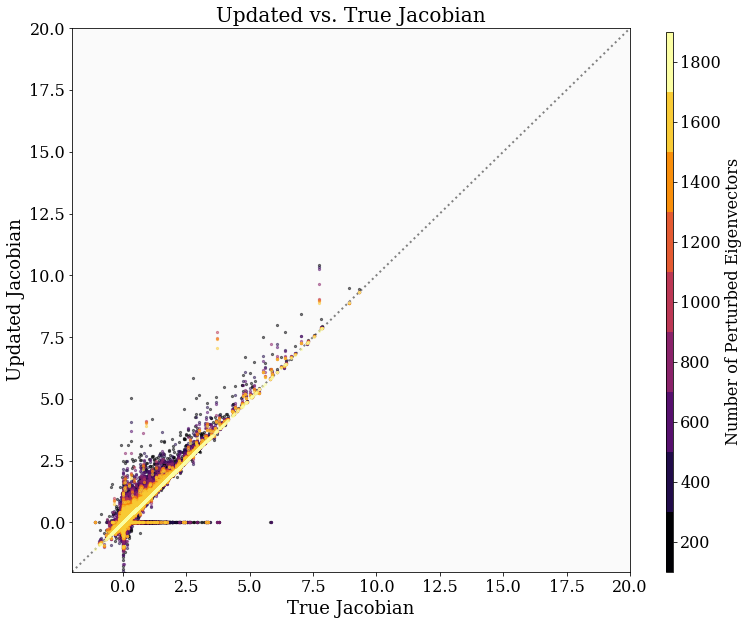

In [102]:
# We can check our results by plotting the regridded Jacobian against
# the true jacobian
fig, ax = plt.subplots(figsize=(10,10))
ax.set_facecolor('0.98')
# ax.scatter(k_true.values, temp, alpha=0.5, s=5, c=colors(1))
c2 = plt.cm.get_cmap('inferno', lut=9)
cnt = 0
for i, kupdate in Kupdates.items():
    ax.scatter(k_true.values, kupdate, alpha=0.5, s=5, c=c2(cnt), label=i)
    cnt += 1
ax.set_ylim(-2,20)
ax.set_xlim(-2,20)
ax.plot((-2,20), (-2,20), c='0.5', lw=2, ls=':', zorder=0)
ax.set_xlabel('True Jacobian', fontsize=18)
ax.set_ylabel('Updated Jacobian', fontsize=18)
ax.set_title('Updated vs. True Jacobian', fontsize=20)
plt.tick_params(axis='both', which='both', labelsize=16)

# ax.legend()
cax = fig.add_axes([0.95, 0.25/2, 0.01, 0.75])
norm = matplotlib.colors.Normalize(vmin=100, vmax=1900)
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=c2, norm=norm,
                                      ticks=np.arange(200, 1801, 200))
cb.set_label('Number of Perturbed Eigenvectors', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=16)

Text(0,0.5,'||K_true - K_update||')

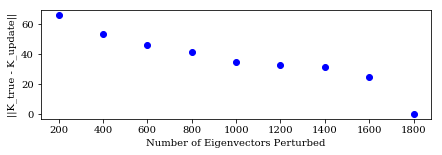

In [85]:
# Quantify the difference
indices = []
diff = []
for i, kupdate in Kupdates.items():
    indices.append(i)
    diff.append(np.linalg.norm(k_true.values - kupdate, 'fro'))

fig, ax = plt.subplots(figsize=(7,2))
ax.scatter(indices, diff, c='blue')
ax.set_xlabel('Number of Eigenvectors Perturbed')
ax.set_ylabel('||K_true - K_update||')

Prior-preconditioned Hessian calculated (0.28 s)
Eigendecomposition complete (0.50 s)


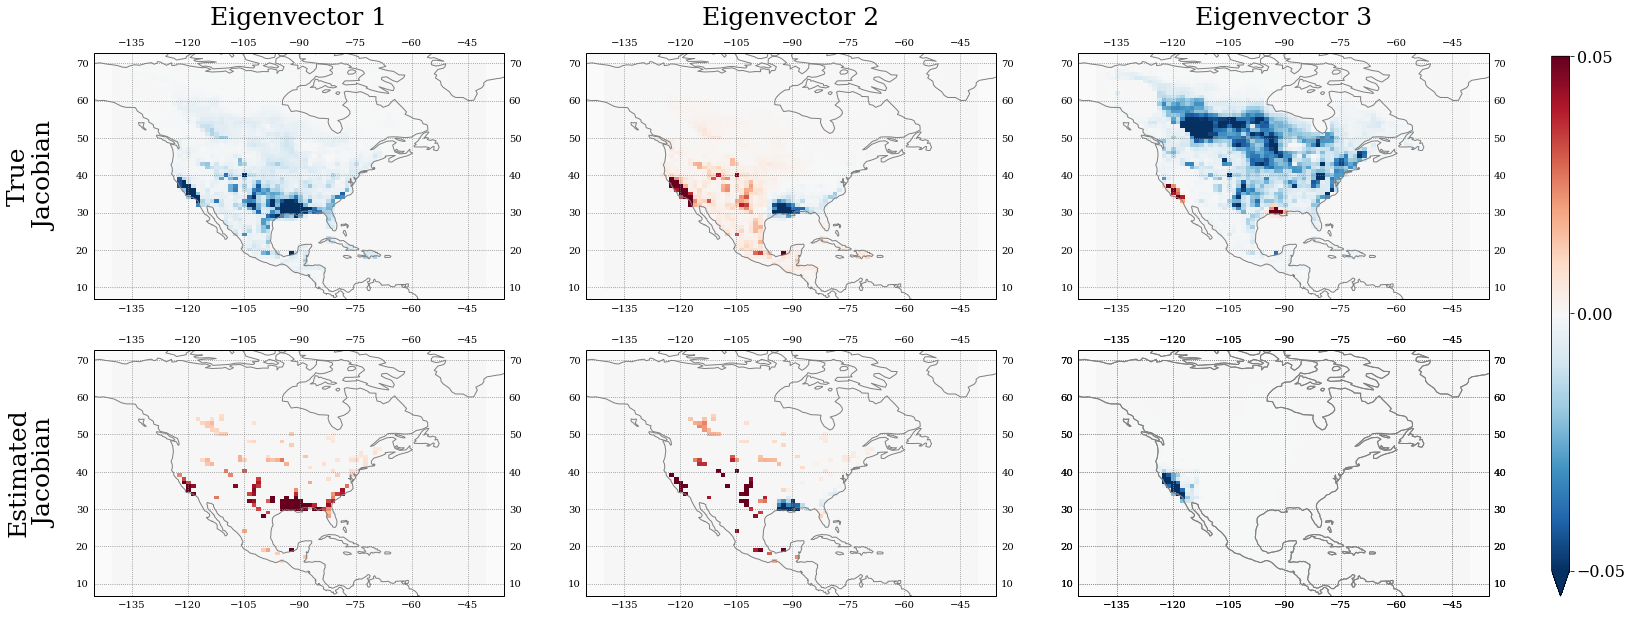

In [40]:
# Start with a first iteration. Just for practice.
temp = Kupdates[200]
pph_temp = inv_rr.calc_pph(temp, sa_vec.values, so_vec.values)
evals_temp, evecs_temp = inv_rr.e_decomp(pph_temp)

# fig, ax = inv_plot.plot_evecs(evecs_temp, clusters_1x125_r)
# plt.suptitle('Eigenvectors (Updated Jacobian)',
#              fontsize=40)
# plt.subplots_adjust(wspace=0.05, hspace=0.3)

fs = 25
plot_options_evecs = {'cmap' : 'RdBu_r',
                      'vmin' : -0.05,
                      'vmax' : 0.05,
                      'add_colorbar' : False}
fig, ax = plt.subplots(2,3,figsize=(25,10),
                      subplot_kw={'projection' : ccrs.PlateCarree()})
for i in range(3):
    ax[0,i] = inv_plot.plot_state(evecs_true[:,i], clusters_1x125_r, 
                                  ax=ax[0,i],
                                  **plot_options_evecs)
    ax[1,i] = inv_plot.plot_state(evecs_temp[:,i], clusters_1x125_r, 
                                  ax=ax[1,i],
                                  **plot_options_evecs)
    ax[0,i].set_title('Eigenvector %d' % (i+1), fontsize=fs, y=1.09)

ax[0,0].text(-0.15, 0.5, 'True\nJacobian', 
             fontsize=fs,
             ha='center', va='center',
             rotation=90, transform=ax[0,0].transAxes)

ax[1,0].text(-0.15, 0.5, 'Estimated\nJacobian', 
             fontsize=fs,
             ha='center', va='center',
             rotation=90, transform=ax[1,0].transAxes)

cax = fig.add_axes([0.935, 0.25/2, 0.01, 0.75])
plot_options_evecs = plot_options_evecs.copy()
del(plot_options_evecs['add_colorbar'])
plot_options_evecs['cbar_ax'] = cax
plot_options_evecs['cbar_kwargs'] = {'ticks': [plot_options_evecs['vmin'], 0, plot_options_evecs['vmax']]}
ax[1,2] = inv_plot.plot_state(evecs[:,2], clusters_1x125_r, 
                              ax=ax[1,2],
                              **plot_options_evecs)
cax.tick_params(labelsize=16)
# evals_pidof = evals/(1 + evals)cax.tick_params(labelsize=30)

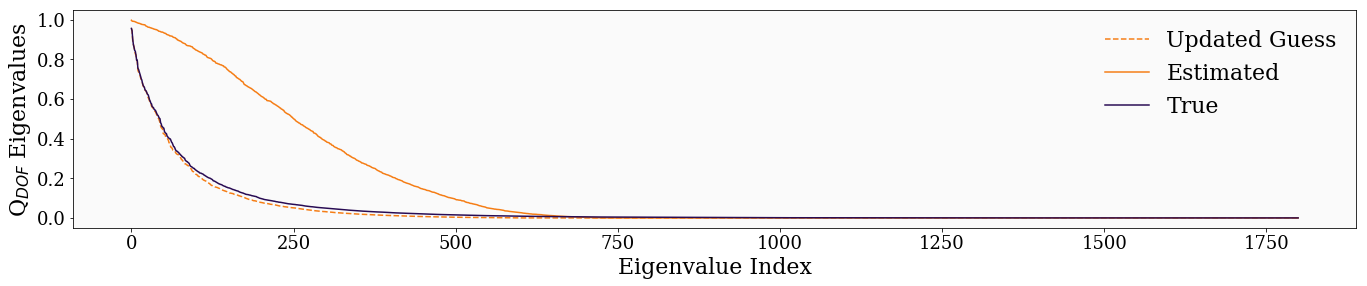

In [151]:
# evals_pidof_est0 = evals/(1 + evals)
evals_pidof_est_ud = evals_temp/(1 + evals_temp)
# evals_pidof_true = evals_true/(1 + evals_true)

# fig, ax = plt.subplots(figsize=(7,3))
# # ax[0].set_title('PPH eigenvalues')
# # ax[0].plot(evals_temp, label='Estimated', c='red')
# # ax[0].plot(evals_true, label='True', c='black')
# # ax[0].legend()

# ax.set_title('QDOF eigenvalues')
# ax.plot(evals_pidof_est0, label='First Guess', c='red')
# ax.plot(evals_pidof_est, label='Updated Guess', c='blue')
# ax.plot(evals_pidof_true, label='True', c='black')
# ax.legend()


fig, ax = plt.subplots(figsize=(23,4))
ax.set_facecolor('0.98')
# ax[0].set_title('PPH eigenvalues')
# ax[0].plot(evals, label='Estimated', c='red')
# ax[0].plot(evals_true, label='True', c='black')
# ax[0].legend()

# ax.set_title(r'Q$_{DOF}$ Eigenvalues', fontsize=20)
ax.plot(evals_pidof_est_ud, label='Updated Guess', c=colors(5), ls='--')
ax.plot(evals_pidof_est, label='Estimated', c=colors(5))
ax.plot(evals_pidof_true, label='True', c=colors(1))
ax.legend(frameon=False, fontsize=22)

ax.set_xlabel('Eigenvalue Index', fontsize=22)
ax.set_ylabel(r'Q$_{DOF}$ Eigenvalues', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=18);

# 200 Perturbation Case Study

In [51]:
# We then create the prolongation and reduction operators, based on 
# the threshold found
pph_2 = inv_rr.calc_pph(K.values, sa_vec.values, so_vec.values)
evals_2, evecs_2 = inv_rr.e_decomp(pph)

# store the first updates in a dictionary. We're only doing one iteration to begin with
# Kupdates = {}
# Komegas = {}
# for idx in range(200, 1801, 200):
#     print(idx)
# idx = 200
# threshold_idx = i #len(evals)
# wk = evecs[:,:idx]
# prolong = (wk.T * (sa_vec**0.5).values).T

# Run the model on our eigenvector perturbations
# k_omega.append(k_true @ prolong)
#     Komegas[idx] 
# ko = k_true @ prolong

# WE CAN TAKE ADVANTAGE OF THE SPARSITY OF K omega HERE
# but also this is a problem because any row where K omega is zero....
# ^^ is this a problem
#     Kupdates[idx] = np.zeros(k[0].shape)
# K200 = {}
# for threshold in [1e-2, 5e-2, 1e-1, 5e-1]:
#     temp = np.zeros(k[0].shape)
#     pbar = tqdm(total=len(k[0].values.flatten()))
#     for i in range(k[0].shape[0]):
#         for j in range(k[0].shape[1]): 
#             pbar.update(1)
#             numer = (ko[i,:]*prolong[j,:]).sum()
#             denom = (prolong[j,:]**2).sum()
#             if denom > threshold:
#                 temp[i,j] = numer/denom
#     K200[threshold] = temp
    
Kupdates200 = {}
# Komegas = {}
for idx in range(200, 1801, 200):
    print(idx)
# idx = 900
#     threshold_idx = i #len(evals)
    wk = evecs[:,:idx]
    prolong = (wk.T * (sa_vec**0.5).values).T

    # Run the model on our eigenvector perturbations
    # k_omega.append(k_true @ prolong)
#     Komegas[idx] 
    ko = k_true @ prolong

    # WE CAN TAKE ADVANTAGE OF THE SPARSITY OF K omega HERE
    # but also this is a problem because any row where K omega is zero....
    # ^^ is this a problem
#     Kupdates[idx] = np.zeros(k[0].shape)
    temp = np.zeros(k[0].shape)
    pbar = tqdm(total=len(k[0].values.flatten()))
    for i in range(k[0].shape[0]):
        for j in range(k[0].shape[1]): 
            pbar.update(1)
            numer = (ko[i,:]*prolong[j,:]).sum()
            denom = (prolong[j,:]**2).sum()
            if denom > 0.1:
                temp[i,j] = numer/denom
    Kupdates[idx] = temp

Prior-preconditioned Hessian calculated (0.38 s)
Eigendecomposition complete (0.68 s)


In [51]:
# We then create the prolongation and reduction operators, based on 
# the threshold found
pph_2 = inv_rr.calc_pph(Kupdates[200], sa_vec.values, so_vec.values)
evals_2, evecs_2 = inv_rr.e_decomp(pph_2)
Kupdates200 = {}
for idx in range(200, 1801, 200):
    print(idx)
    wk = evecs_2[:,:idx]
    prolong = (wk.T * (sa_vec**0.5).values).T

    # Run the model on our eigenvector perturbations
    ko = k_true @ prolong

    temp = np.zeros(Kupdates[200].shape)
    pbar = tqdm(total=len(Kupdates[200].flatten()))
    for i in range(Kupdates[200].shape[0]):
        for j in range(Kupdates[200].shape[1]): 
            pbar.update(1)
            numer = (ko[i,:]*prolong[j,:]).sum()
            denom = (prolong[j,:]**2).sum()
            if denom > 0.1:
                temp[i,j] = numer/denom
    Kupdates200[idx] = temp
    
pph_2 = inv_rr.calc_pph(Kupdates[400], sa_vec.values, so_vec.values)
evals_2, evecs_2 = inv_rr.e_decomp(pph_2)
Kupdates400 = {}
for idx in range(200, 1801, 200):
    print(idx)
    wk = evecs_2[:,:idx]
    prolong = (wk.T * (sa_vec**0.5).values).T

    # Run the model on our eigenvector perturbations
    ko = k_true @ prolong

    temp = np.zeros(Kupdates[400].shape)
    pbar = tqdm(total=len(Kupdates[400].flatten()))
    for i in range(Kupdates[400].shape[0]):
        for j in range(Kupdates[400].shape[1]): 
            pbar.update(1)
            numer = (ko[i,:]*prolong[j,:]).sum()
            denom = (prolong[j,:]**2).sum()
            if denom > 0.1:
                temp[i,j] = numer/denom
    Kupdates400[idx] = temp
 
   
pph_2 = inv_rr.calc_pph(Kupdates[600], sa_vec.values, so_vec.values)
evals_2, evecs_2 = inv_rr.e_decomp(pph_2)
Kupdates600 = {}
for idx in range(200, 1801, 200):
    print(idx)
    wk = evecs_2[:,:idx]
    prolong = (wk.T * (sa_vec**0.5).values).T

    # Run the model on our eigenvector perturbations
    ko = k_true @ prolong

    temp = np.zeros(Kupdates[600].shape)
    pbar = tqdm(total=len(Kupdates[600].flatten()))
    for i in range(Kupdates[600].shape[0]):
        for j in range(Kupdates[600].shape[1]): 
            pbar.update(1)
            numer = (ko[i,:]*prolong[j,:]).sum()
            denom = (prolong[j,:]**2).sum()
            if denom > 0.1:
                temp[i,j] = numer/denom
    Kupdates600[idx] = temp

Prior-preconditioned Hessian calculated (0.39 s)
Eigendecomposition complete (0.52 s)
200


400


600


800


1000


1200


1400


1600


1800


Prior-preconditioned Hessian calculated (0.32 s)
Eigendecomposition complete (0.59 s)
200


400


600


800


1000


1200


1400


1600


1800


Prior-preconditioned Hessian calculated (0.39 s)
Eigendecomposition complete (0.75 s)
200


400


600


800


1000


1200


1400


1600


1800


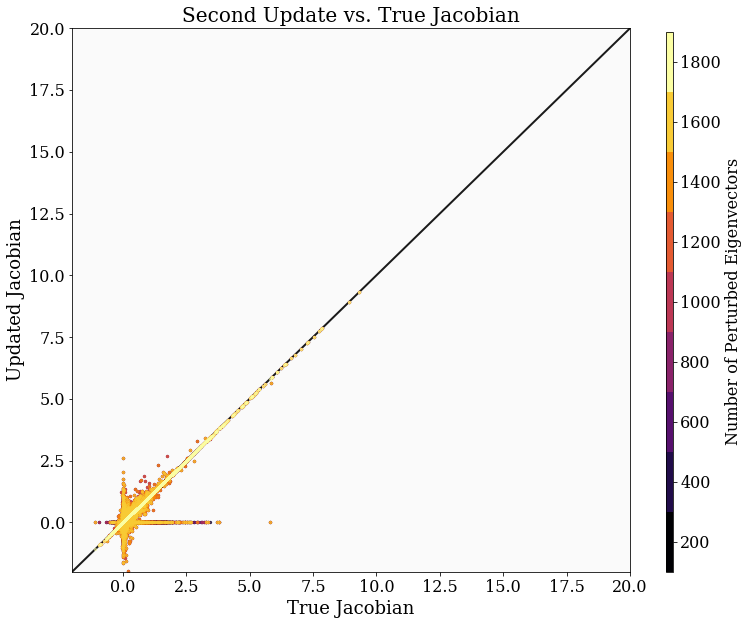

In [90]:
# We can check our results by plotting the regridded Jacobian against
# the true jacobian
fig, ax = plt.subplots(figsize=(10,10))
ax.set_facecolor('0.98')
# ax.scatter(k_true.values, temp, alpha=0.5, s=5, c=colors(1))
c2 = plt.cm.get_cmap('inferno', lut=9)
cnt = 0
for i, kupdate in Kupdates200.items():
    ax.scatter(k_true.values, kupdate, alpha=0.5, s=5, c=c2(cnt), label=i)
    cnt += 1
ax.set_ylim(-2,20)
ax.set_xlim(-2,20)
ax.plot((-2,20), (-2,20), c='0.1', lw=2, zorder=0)
ax.set_xlabel('True Jacobian', fontsize=18)
ax.set_ylabel('Updated Jacobian', fontsize=18)
ax.set_title('Second Update vs. True Jacobian', fontsize=20)
plt.tick_params(axis='both', which='both', labelsize=16)

# ax.legend()
cax = fig.add_axes([0.95, 0.25/2, 0.01, 0.75])
norm = matplotlib.colors.Normalize(vmin=100, vmax=1900)
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=c2, norm=norm,
                                      ticks=np.arange(200, 1801, 200))
cb.set_label('Number of Perturbed Eigenvectors', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=16)

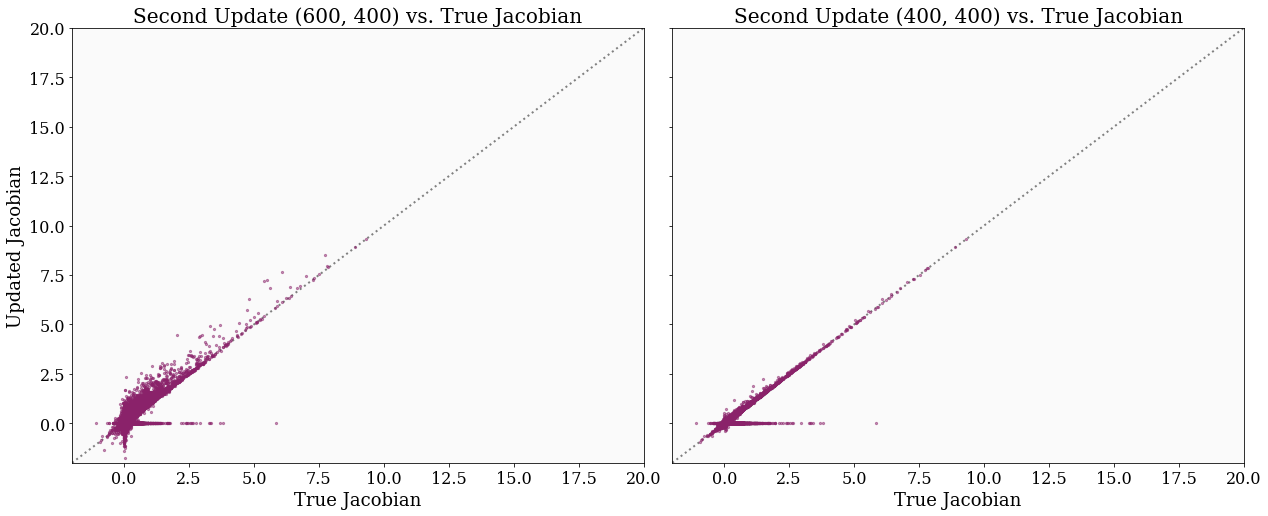

In [218]:
# We can check our results by plotting the regridded Jacobian against
# the true jacobian
fig, axis = plt.subplots(1,2,figsize=(21,10),sharey=True)
plt.subplots_adjust(wspace=0.05)

# ax.scatter(k_true.values, temp, alpha=0.5, s=5, c=colors(1))
axis[0].set_title('Second Update (600, 400) vs. True Jacobian', fontsize=20)
axis[0].scatter(k_true.values, Kupdates600[400], alpha=0.5, s=5, c=c2(3))

axis[1].set_title('Second Update (400, 400) vs. True Jacobian', fontsize=20)
axis[1].scatter(k_true.values, Kupdates400[400], alpha=0.5, s=5, c=c2(3))

axis[0].set_ylabel('Updated Jacobian', fontsize=18)
for ax in axis:
    ax.set_facecolor('0.98')
    ax.set_ylim(-2,20)
    ax.set_xlim(-2,20)
    ax.plot((-2,20), (-2,20), c='0.5', lw=2, ls=':', zorder=0)
    ax.set_xlabel('True Jacobian', fontsize=18)
    ax.tick_params(axis='both', which='both', labelsize=16)

# ax.legend()
# cax = fig.add_axes([0.95, 0.25/2, 0.01, 0.75])
# norm = matplotlib.colors.Normalize(vmin=100, vmax=1900)
# cb = matplotlib.colorbar.ColorbarBase(cax, cmap=c2, norm=norm,
#                                       ticks=np.arange(200, 1801, 200))
# cb.set_label('Number of Perturbed Eigenvectors', fontsize=16)


[Text(0,0,'0'),
 Text(0,0,'200'),
 Text(0,0,'400'),
 Text(0,0,'600'),
 Text(0,0,'800'),
 Text(0,0,'1000'),
 Text(0,0,'1200'),
 Text(0,0,'1400'),
 Text(0,0,'1600'),
 Text(0,0,'1800')]

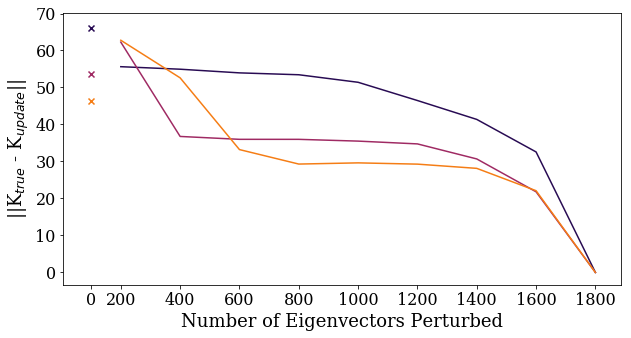

In [88]:
# Quantify the difference
indices = []
diff = []
for i, kupdate in Kupdates200.items():
    indices.append(i)
    diff.append(np.linalg.norm(k_true.values - kupdate, 'fro'))

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(indices, diff, c=colors(1))#, s=15)
ax.scatter(100, np.linalg.norm(k_true.values - Kupdates[200], 'fro'), 
           c=colors(1), 
           marker='x')
ax.set_xlabel('Number of Eigenvectors Perturbed', fontsize=18)
ax.set_ylabel(r'||K$_{true}$ - K$_{update}$||', fontsize=18)
plt.tick_params('both', labelsize=16)

indices = []
diff = []
for i, kupdate in Kupdates400.items():
    indices.append(i)
    diff.append(np.linalg.norm(k_true.values - kupdate, 'fro'))

ax.plot(indices, diff, c=colors(3))#, s=15)
ax.scatter(100, np.linalg.norm(k_true.values - Kupdates[400], 'fro'), 
           c=colors(3), 
           marker='x')

indices = []
diff = []
for i, kupdate in Kupdates600.items():
    indices.append(i)
    diff.append(np.linalg.norm(k_true.values - kupdate, 'fro'))

ax.plot(indices, diff, c=colors(5))#, s=15)
ax.scatter(100, np.linalg.norm(k_true.values - Kupdates[600], 'fro'), 
           c=colors(5), 
           marker='x')

ax.set_xticks([100] + [x for x in np.arange(200, 1801, 200)])
ax.set_xticklabels([0] + [x for x in np.arange(200, 1801, 200)])

In [57]:
np.linalg.norm(k_true.values - Kupdates[200], 'fro')

66.12076386752636

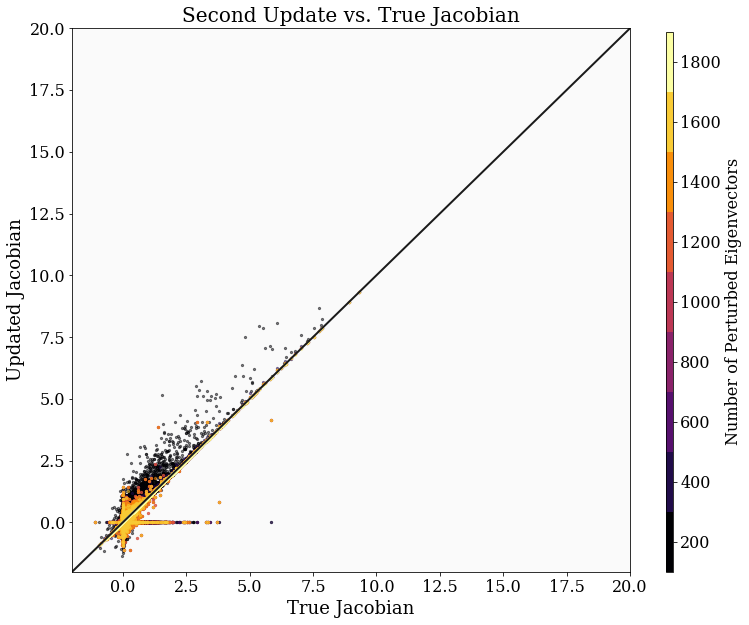

In [54]:
# We can check our results by plotting the regridded Jacobian against
# the true jacobian
fig, ax = plt.subplots(figsize=(10,10))
ax.set_facecolor('0.98')
# ax.scatter(k_true.values, temp, alpha=0.5, s=5, c=colors(1))
c2 = plt.cm.get_cmap('inferno', lut=9)
cnt = 0
for i, kupdate in Kupdates400.items():
    ax.scatter(k_true.values, kupdate, alpha=0.5, s=5, c=c2(cnt), label=i)
    cnt += 1
ax.set_ylim(-2,20)
ax.set_xlim(-2,20)
ax.plot((-2,20), (-2,20), c='0.1', lw=2)
ax.set_xlabel('True Jacobian', fontsize=18)
ax.set_ylabel('Updated Jacobian', fontsize=18)
ax.set_title('Second Update vs. True Jacobian', fontsize=20)
plt.tick_params(axis='both', which='both', labelsize=16)

# ax.legend()
cax = fig.add_axes([0.95, 0.25/2, 0.01, 0.75])
norm = matplotlib.colors.Normalize(vmin=100, vmax=1900)
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=c2, norm=norm,
                                      ticks=np.arange(200, 1801, 200))
cb.set_label('Number of Perturbed Eigenvectors', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=16)

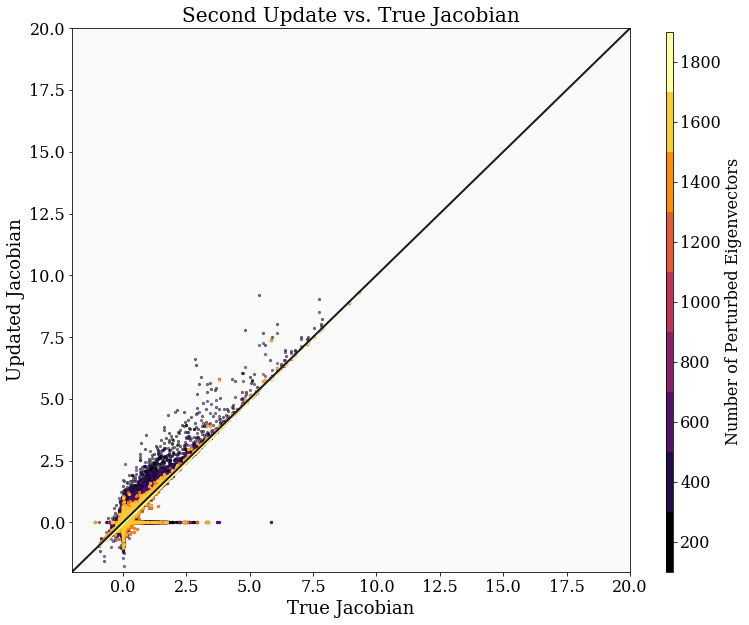

In [55]:
# We can check our results by plotting the regridded Jacobian against
# the true jacobian
fig, ax = plt.subplots(figsize=(10,10))
ax.set_facecolor('0.98')
# ax.scatter(k_true.values, temp, alpha=0.5, s=5, c=colors(1))
c2 = plt.cm.get_cmap('inferno', lut=9)
cnt = 0
for i, kupdate in Kupdates600.items():
    ax.scatter(k_true.values, kupdate, alpha=0.5, s=5, c=c2(cnt), label=i)
    cnt += 1
ax.set_ylim(-2,20)
ax.set_xlim(-2,20)
ax.plot((-2,20), (-2,20), c='0.1', lw=2)
ax.set_xlabel('True Jacobian', fontsize=18)
ax.set_ylabel('Updated Jacobian', fontsize=18)
ax.set_title('Second Update vs. True Jacobian', fontsize=20)
plt.tick_params(axis='both', which='both', labelsize=16)

# ax.legend()
cax = fig.add_axes([0.95, 0.25/2, 0.01, 0.75])
norm = matplotlib.colors.Normalize(vmin=100, vmax=1900)
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=c2, norm=norm,
                                      ticks=np.arange(200, 1801, 200))
cb.set_label('Number of Perturbed Eigenvectors', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=16)

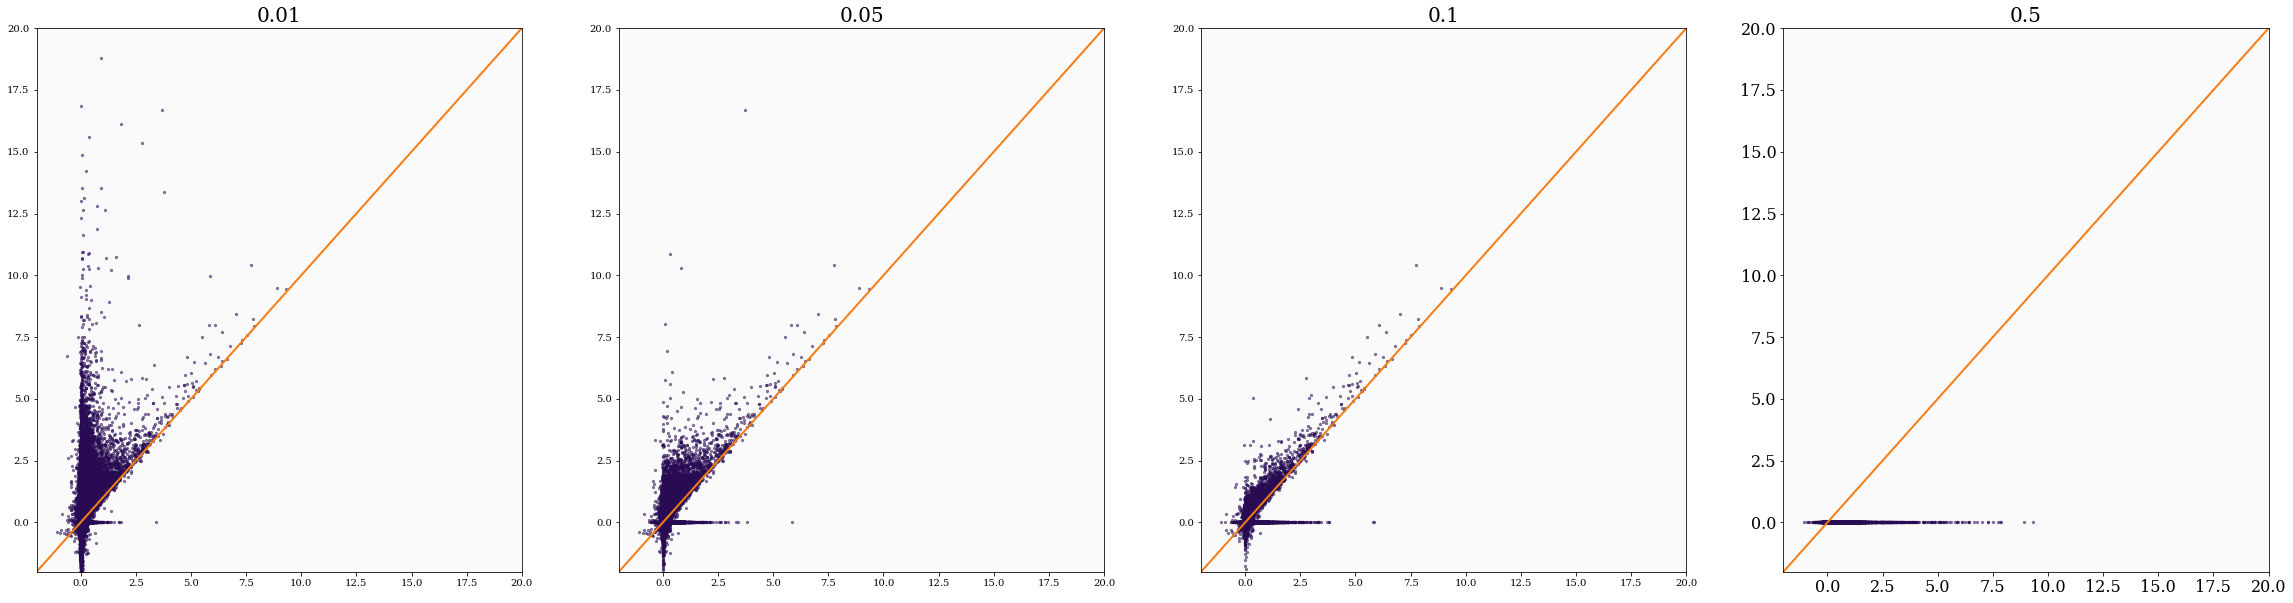

In [53]:
# We can check our results by plotting the regridded Jacobian against
# the true jacobian
fig, ax = plt.subplots(1,4,figsize=(40,10))
# ax.scatter(k_true.values, temp, alpha=0.5, s=5, c=colors(1))
cnt = 0
for i, kupdate in K200.items():
    ax[cnt].set_title(str(i), fontsize=20)
    ax[cnt].set_facecolor('0.98')
    ax[cnt].scatter(k_true.values, kupdate, alpha=0.5, s=5, c=colors(1), label=i)
    ax[cnt].set_ylim(-2,20)
    ax[cnt].set_xlim(-2,20)
    ax[cnt].plot((-2,20), (-2,20), c=colors(5), lw=2)
#     ax[cnt].set_xlabel('True Jacobian', fontsize=18)
#     ax[cnt].set_ylabel('Updated Jacobian', fontsize=18)
#     ax[cnt].set_title('Updated vs. True Jacobian', fontsize=20)
#     ax[cnt].legend()
    plt.tick_params(axis='both', which='major', labelsize=16)
    cnt += 1;

In [ ]:
## ITERATE
# We then create the prolongation and reduction operators, based on 
# the threshold found
pph = inv_rr.calc_pph(Kupdates[200].values, sa_vec.values, so_vec.values)
evals, evecs = inv_rr.e_decomp(pph)

# store the first updates in a dictionary. We're only doing one iteration to begin with
Kupdates2 = {}
# for idx in range(200, 1801, 200):
#     print(idx)
# idx = 900
    threshold_idx = i #len(evals)
    wk = evecs[:,:idx]
    prolong = (wk.T * (sa_vec**0.5).values).T

    # Run the model on our eigenvector perturbations
    # k_omega.append(k_true @ prolong)
#     Komegas[idx] 
    ko = k_true @ prolong

    # WE CAN TAKE ADVANTAGE OF THE SPARSITY OF K omega HERE
    # but also this is a problem because any row where K omega is zero....
    # ^^ is this a problem
#     Kupdates[idx] = np.zeros(k[0].shape)
    temp = np.zeros(k[0].shape)
    pbar = tqdm(total=len(k[0].values.flatten()))
    for i in range(k[0].shape[0]):
        for j in range(k[0].shape[1]): 
            pbar.update(1)
            numer = (ko[i,:]*prolong[j,:]).sum()
            denom = (prolong[j,:]**2).sum()
            if denom > 0.1:
                temp[i,j] = numer/denom
    Kupdates[idx] = temp

In [162]:
## SOLVE INVERSION
### STANDARD METHOD
xhats = {}
for i, kupdate in Kupdates.items():
    c = y_base - kupdate @ xa.values
    shat = np.linalg.inv(kupdate.T @ (0.05*so_inv) @ kupdate + sa_inv)
    g = shat @ kupdate.T @ (0.05*so_inv)
    xhat = xa.values + (g @ (y - kupdate @ xa.values - c))
    xhats[i] = np.asarray(xhat).reshape(-1)
    
xhats200 = {}
for i, kupdate in Kupdates200.items():
    c = y_base - kupdate @ xa.values
    shat = np.linalg.inv(kupdate.T @ (0.05*so_inv) @ kupdate + sa_inv)
    g = shat @ kupdate.T @ (0.05*so_inv)
    xhat = xa.values + (g @ (y - kupdate @ xa.values - c))
    xhats200[i] = np.asarray(xhat).reshape(-1)
    
xhats400 = {}
for i, kupdate in Kupdates400.items():
    c = y_base - kupdate @ xa.values
    shat = np.linalg.inv(kupdate.T @ (0.05*so_inv) @ kupdate + sa_inv)
    g = shat @ kupdate.T @ (0.05*so_inv)
    xhat = xa.values + (g @ (y - kupdate @ xa.values - c))
    xhats400[i] = np.asarray(xhat).reshape(-1)
    
xhats600 = {}
for i, kupdate in Kupdates600.items():
    c = y_base - kupdate @ xa.values
    shat = np.linalg.inv(kupdate.T @ (0.05*so_inv) @ kupdate + sa_inv)
    g = shat @ kupdate.T @ (0.05*so_inv)
    xhat = xa.values + (g @ (y - kupdate @ xa.values - c))
    xhats600[i] = np.asarray(xhat).reshape(-1)

In [116]:
### TRUE STANDARD METHOD
c = y_base - k_true @ xa.values
shat = np.linalg.inv(k_true.values.T @ (0.05*so_inv) @ k_true.values + sa_inv)
g = shat @ k_true.values.T @ (0.05*so_inv)
xhat_true = xa.values + (g @ (y - k_true.values @ xa.values - c))
xhat_true = np.asarray(xhat_true).reshape(-1)

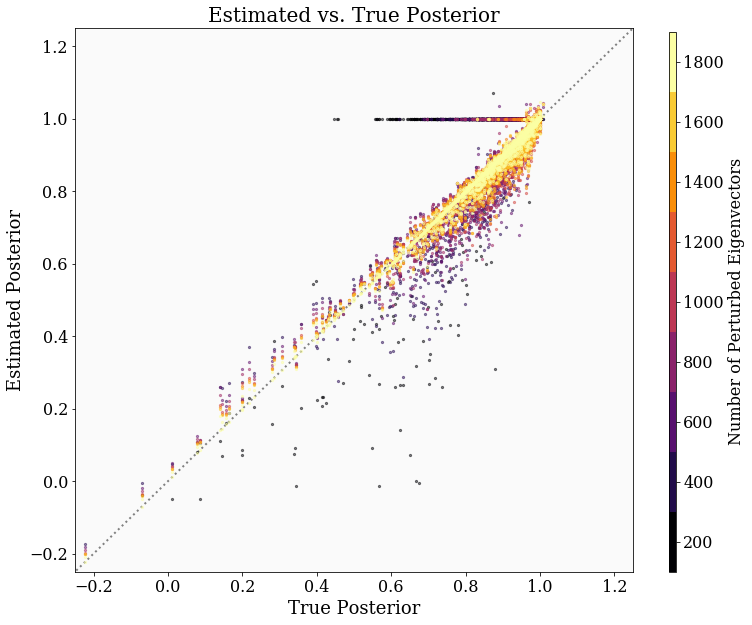

In [133]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_facecolor('0.98')
cnt = 0
for i, xhat in xhats.items():
    ax.scatter(xhat_true, xhat, alpha=0.5, s=5, c=colors(cnt), label=i)
    cnt += 1
# ax.set_ylim(-2,20)
# ax.set_xlim(-2,20)
# ax.plot((-2,20), (-2,20), c=colors(5), lw=2)
ax.set_xlabel('True Posterior', fontsize=18)
ax.set_ylabel('Estimated Posterior', fontsize=18)
ax.set_title('Estimated vs. True Posterior', fontsize=20)
ax.plot((-2,20), (-2,20), c='0.5', lw=2, ls=':', zorder=0)
ax.set_xlim(-0.25, 1.25)
ax.set_ylim(-0.25, 1.25)
plt.tick_params(axis='both', which='major', labelsize=16)

cax = fig.add_axes([0.95, 0.25/2, 0.01, 0.75])
norm = matplotlib.colors.Normalize(vmin=100, vmax=1900)
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=c2, norm=norm,
                                      ticks=np.arange(200, 1801, 200))
cb.set_label('Number of Perturbed Eigenvectors', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=16);

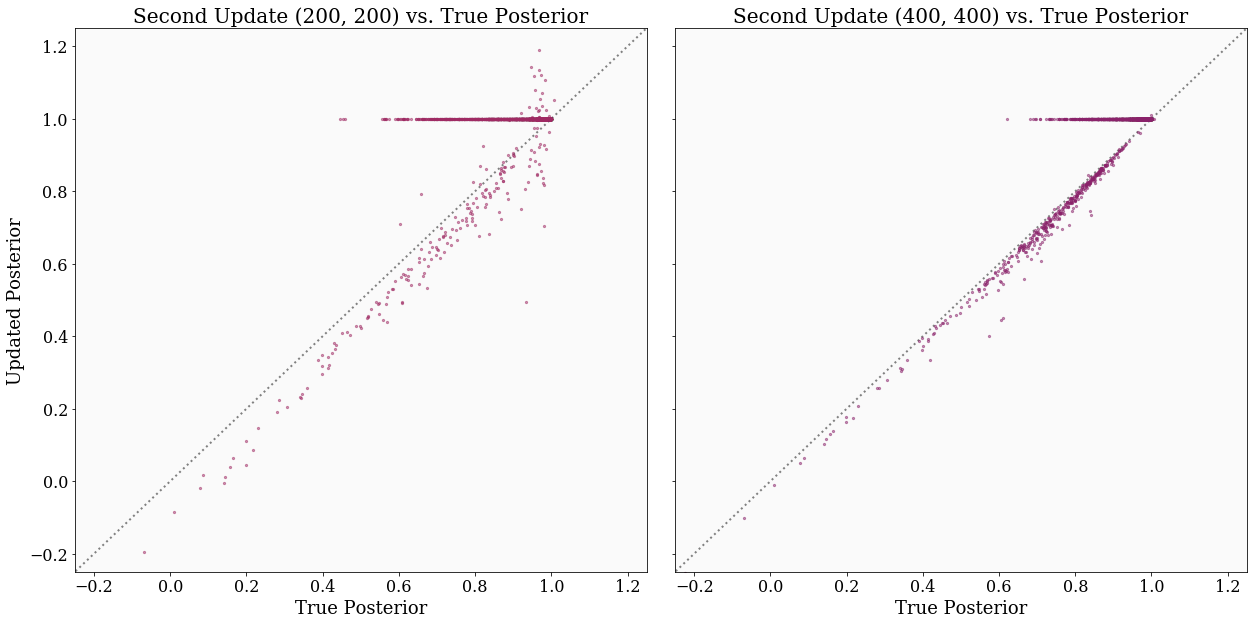

In [169]:
# We can check our results by plotting the regridded Jacobian against
# the true jacobian
fig, axis = plt.subplots(1,2,figsize=(21,10),sharey=True)
plt.subplots_adjust(wspace=0.05)

# ax.scatter(k_true.values, temp, alpha=0.5, s=5, c=colors(1))
axis[0].set_title('Second Update (200, 200) vs. True Posterior', fontsize=20)
axis[0].scatter(xhat_true, xhats200[200], alpha=0.5, s=5, c=colors(3))

axis[1].set_title('Second Update (400, 400) vs. True Posterior', fontsize=20)
axis[1].scatter(xhat_true, xhats400[400], alpha=0.5, s=5, c=c2(3))

axis[0].set_ylabel('Updated Posterior', fontsize=18)
for ax in axis:
    ax.set_facecolor('0.98')
    ax.set_xlim(-0.25, 1.25)
    ax.set_ylim(-0.25, 1.25)
    ax.plot((-2,20), (-2,20), c='0.5', lw=2, ls=':', zorder=0)
    ax.set_xlabel('True Posterior', fontsize=18)
    ax.tick_params(axis='both', which='both', labelsize=16)

# ax.legend()
# cax = fig.add_axes([0.95, 0.25/2, 0.01, 0.75])
# norm = matplotlib.colors.Normalize(vmin=100, vmax=1900)
# cb = matplotlib.colorbar.ColorbarBase(cax, cmap=c2, norm=norm,
#                                       ticks=np.arange(200, 1801, 200))
# cb.set_label('Number of Perturbed Eigenvectors', fontsize=16)


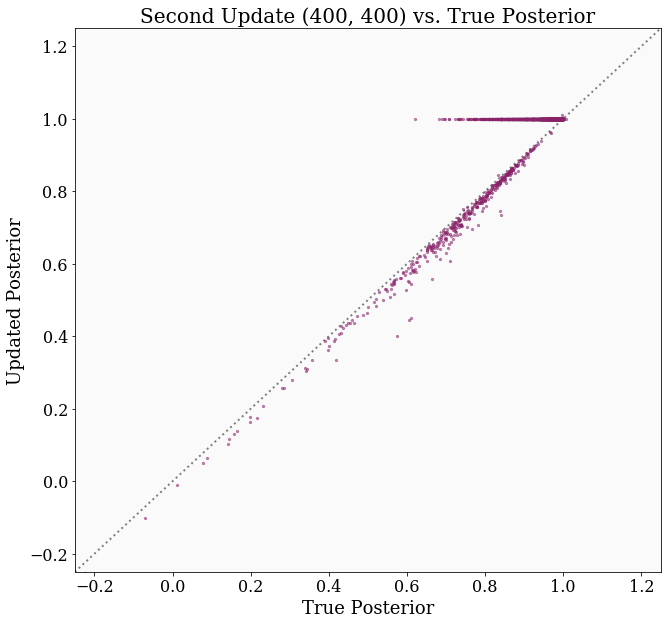

In [220]:
# We can check our results by plotting the regridded Jacobian against
# the true jacobian
fig, ax = plt.subplots(1,1,figsize=(10.5,10),sharey=True)
plt.subplots_adjust(wspace=0.05)

ax.set_title('Second Update (400, 400) vs. True Posterior', fontsize=20)
ax.scatter(xhat_true, xhats400[400], alpha=0.5, s=5, c=c2(3))
ax.set_ylabel('Updated Posterior', fontsize=18)
ax.set_facecolor('0.98')
ax.set_xlim(-0.25, 1.25)
ax.set_ylim(-0.25, 1.25)
ax.plot((-2,20), (-2,20), c='0.5', lw=2, ls=':', zorder=0)
ax.set_xlabel('True Posterior', fontsize=18)
ax.tick_params(axis='both', which='both', labelsize=16)

# ax.legend()
# cax = fig.add_axes([0.95, 0.25/2, 0.01, 0.75])
# norm = matplotlib.colors.Normalize(vmin=100, vmax=1900)
# cb = matplotlib.colorbar.ColorbarBase(cax, cmap=c2, norm=norm,
#                                       ticks=np.arange(200, 1801, 200))
# cb.set_label('Number of Perturbed Eigenvectors', fontsize=16)


Prior-preconditioned Hessian calculated (0.27 s)
Eigendecomposition complete (0.58 s)


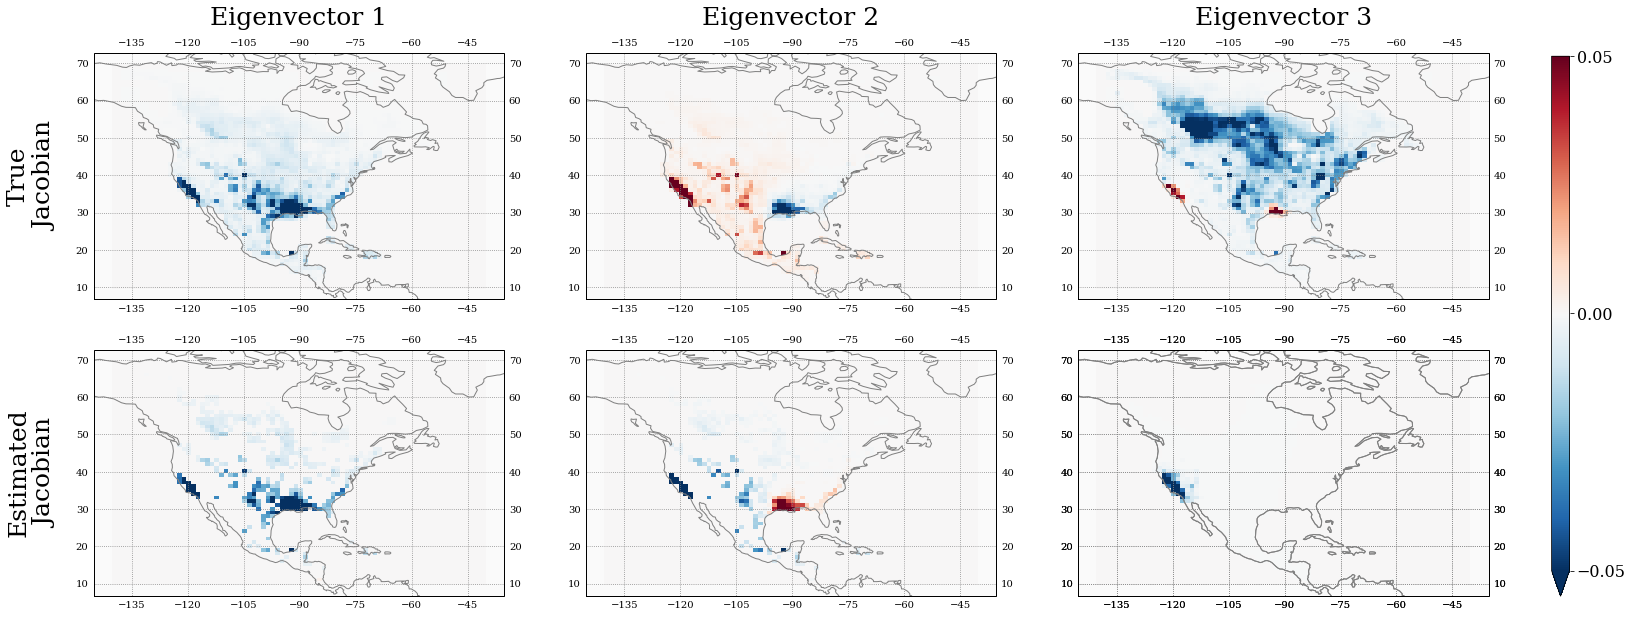

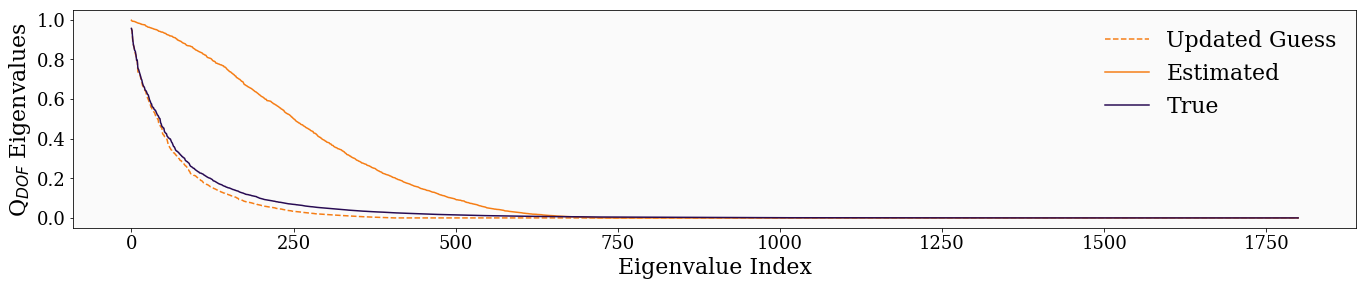

In [170]:
# Start with a first iteration. Just for practice.
temp = Kupdates400[400]
pph_temp = inv_rr.calc_pph(temp, sa_vec.values, so_vec.values)
evals_temp, evecs_temp = inv_rr.e_decomp(pph_temp)

# fig, ax = inv_plot.plot_evecs(evecs_temp, clusters_1x125_r)
# plt.suptitle('Eigenvectors (Updated Jacobian)',
#              fontsize=40)
# plt.subplots_adjust(wspace=0.05, hspace=0.3)

fs = 25
plot_options_evecs = {'cmap' : 'RdBu_r',
                      'vmin' : -0.05,
                      'vmax' : 0.05,
                      'add_colorbar' : False}
fig, ax = plt.subplots(2,3,figsize=(25,10),
                      subplot_kw={'projection' : ccrs.PlateCarree()})
for i in range(3):
    ax[0,i] = inv_plot.plot_state(evecs_true[:,i], clusters_1x125_r, 
                                  ax=ax[0,i],
                                  **plot_options_evecs)
    ax[1,i] = inv_plot.plot_state(evecs_temp[:,i], clusters_1x125_r, 
                                  ax=ax[1,i],
                                  **plot_options_evecs)
    ax[0,i].set_title('Eigenvector %d' % (i+1), fontsize=fs, y=1.09)

ax[0,0].text(-0.15, 0.5, 'True\nJacobian', 
             fontsize=fs,
             ha='center', va='center',
             rotation=90, transform=ax[0,0].transAxes)

ax[1,0].text(-0.15, 0.5, 'Estimated\nJacobian', 
             fontsize=fs,
             ha='center', va='center',
             rotation=90, transform=ax[1,0].transAxes)

cax = fig.add_axes([0.935, 0.25/2, 0.01, 0.75])
plot_options_evecs = plot_options_evecs.copy()
del(plot_options_evecs['add_colorbar'])
plot_options_evecs['cbar_ax'] = cax
plot_options_evecs['cbar_kwargs'] = {'ticks': [plot_options_evecs['vmin'], 0, plot_options_evecs['vmax']]}
ax[1,2] = inv_plot.plot_state(evecs[:,2], clusters_1x125_r, 
                              ax=ax[1,2],
                              **plot_options_evecs)
cax.tick_params(labelsize=16)
# evals_pidof = evals/(1 + evals)cax.tick_params(labelsize=30)

# evals_pidof_est0 = evals/(1 + evals)
evals_pidof_est_ud = evals_temp/(1 + evals_temp)

fig, ax = plt.subplots(figsize=(23,4))
ax.set_facecolor('0.98')

ax.plot(evals_pidof_est_ud, label='Updated Guess', c=colors(5), ls='--')
ax.plot(evals_pidof_est, label='Estimated', c=colors(5))
ax.plot(evals_pidof_true, label='True', c=colors(1))
ax.legend(frameon=False, fontsize=22)

ax.set_xlabel('Eigenvalue Index', fontsize=22)
ax.set_ylabel(r'Q$_{DOF}$ Eigenvalues', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=18);

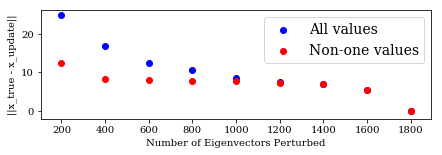

In [113]:
# Quantify the difference
indices = []
diff = []
diff_non_zero = []
for i, xhat in xhats.items():
    indices.append(i)
    diff.append(np.linalg.norm(xhat_true - xhat))
    diff_non_zero.append(np.linalg.norm(xhat_true[xhat != 1] - xhat[xhat != 1]))

fig, ax = plt.subplots(figsize=(7,2))
ax.scatter(indices, diff, c='blue', label='All values')
ax.scatter(indices, diff_non_zero, c='red', label='Non-one values')
ax.set_xlabel('Number of Eigenvectors Perturbed')
ax.set_ylabel('||x_true - x_update||')
ax.legend(fontsize=14)

Text(0.5,1.07,'1600 Eigenvectors Estimate')

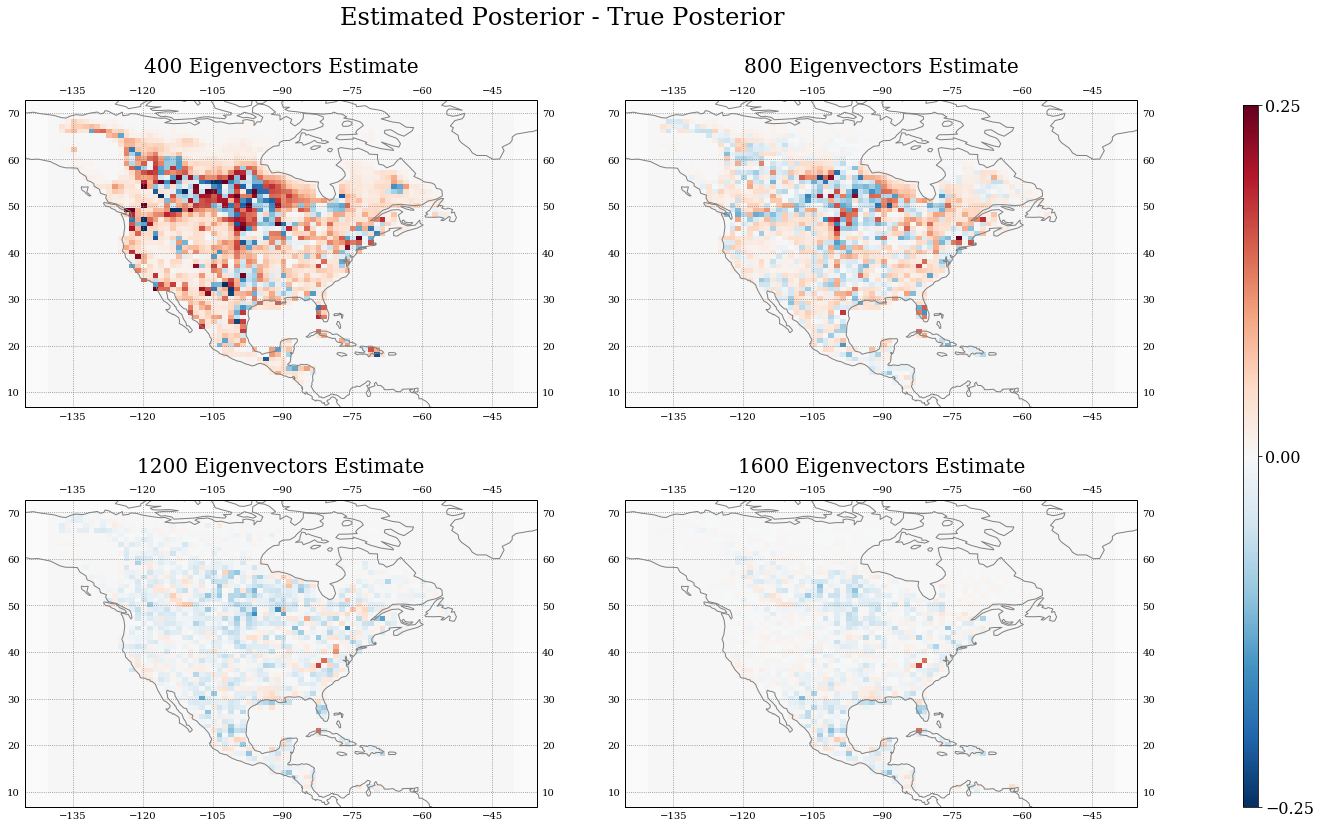

In [146]:
n = 2
fig, ax = plt.subplots(2,n,figsize=(2*n*5.25,2*6.5),
                           subplot_kw={'projection' : ccrs.PlateCarree()})
plt.subplots_adjust(hspace=0.3, wspace=0.05)
cax = fig.add_axes([0.95, 0.25/2, 0.01, 0.75])
fig.suptitle('Estimated Posterior - True Posterior', fontsize=24, y=0.98)
# for i, evec_num in enumerate([400, 1000, 1600]):
plot_options = {'cmap' : 'RdBu_r',
                'vmin' : -0.25,
                'vmax' : 0.25,
                'add_colorbar' : False}
#                 'cbar_kwargs' : {'label' : 'Scaling Factors'}}

inv_plot.plot_state(xhats[400]-xhat_true, clusters_1x125_r, 
                    ax=ax[0,0], **plot_options)

inv_plot.plot_state(xhats[800]-xhat_true, clusters_1x125_r, 
                    ax=ax[0,1], **plot_options)

inv_plot.plot_state(xhats[1200]-xhat_true, clusters_1x125_r, 
                    ax=ax[1,0], **plot_options)


pos = plot_options.copy()
del(pos['add_colorbar'])
pos['cbar_ax'] = cax
pos['cbar_kwargs'] = {'ticks': [pos['vmin'], 0, pos['vmax']]}
cax.tick_params(labelsize=16)
inv_plot.plot_state(xhats[1600]-xhat_true, clusters_1x125_r, 
                    ax=ax[1,1], **pos)

ax[0,0].set_title('400 Eigenvectors Estimate', fontsize=20, y=1.07)
ax[0,1].set_title('800 Eigenvectors Estimate', fontsize=20, y=1.07)
ax[1,0].set_title('1200 Eigenvectors Estimate', fontsize=20, y=1.07)
ax[1,1].set_title('1600 Eigenvectors Estimate', fontsize=20, y=1.07)

Text(0,0.5,'Estimated Posterior - True Posterior')

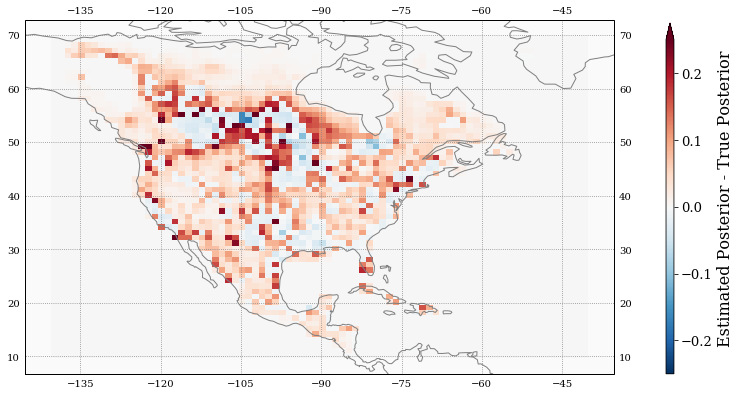

In [192]:
fig, ax = plt.subplots(figsize=(11,6.5),
                           subplot_kw={'projection' : ccrs.PlateCarree()})
cax = fig.add_axes([0.95, 0.25/2, 0.01, 0.75])
plot_options = {'cmap' : 'RdBu_r',
                'vmin' : -0.25,
                'vmax' : 0.25,
#                 'add_colorbar' : False}
                'cbar_ax' : cax,
                'cbar_kwargs' : {'label' : 'Estimated Posterior - True Posterior'}}

inv_plot.plot_state(xhats400[400]-xhat_true, clusters_1x125_r, ax, **plot_options)
cax.tick_params(labelsize=13)
cax.set_ylabel('Estimated Posterior - True Posterior', fontsize=16)

Text(0,0.5,'Averaging Kernel')

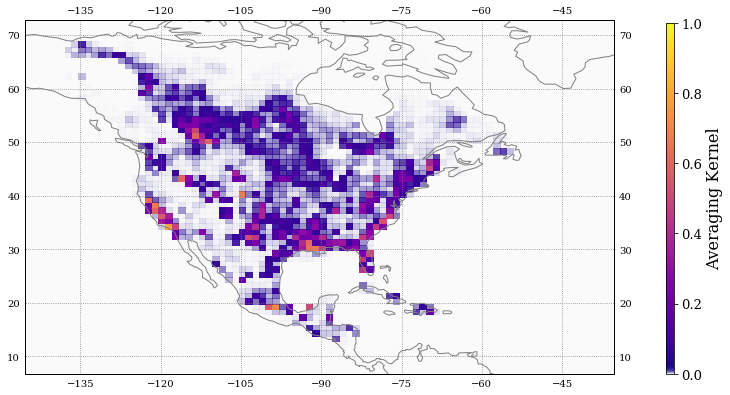

In [213]:
def calc_avker(k, sa_v, so_v):
    sa = sparse.diags(sa_v.values)
    so = sparse.diags(so_v.values)
    avker = sa @ k.T @ np.linalg.inv(k @ sa @ k.T + so) @ k
    return avker

avker400400 = calc_avker(k_true.values, sa_vec, so_vec)

fig, ax = plt.subplots(figsize=(11,6.5),
                           subplot_kw={'projection' : ccrs.PlateCarree()})
cax = fig.add_axes([0.95, 0.25/2, 0.01, 0.75])
plot_options = {'cmap' : inv_plot.cm_transparent_at_zero('plasma'),
                'vmin' : 0,
                'vmax' : 1,
#                 'add_colorbar' : False}
                'cbar_ax' : cax,
                'cbar_kwargs' : {'label' : 'Estimated Posterior - True Posterior'}}

inv_plot.plot_state(np.diag(avker400400), clusters_1x125_r, ax, **plot_options)
cax.tick_params(labelsize=13)
cax.set_ylabel('Averaging Kernel', fontsize=16)

Text(0,0.5,'Estimated Posterior')

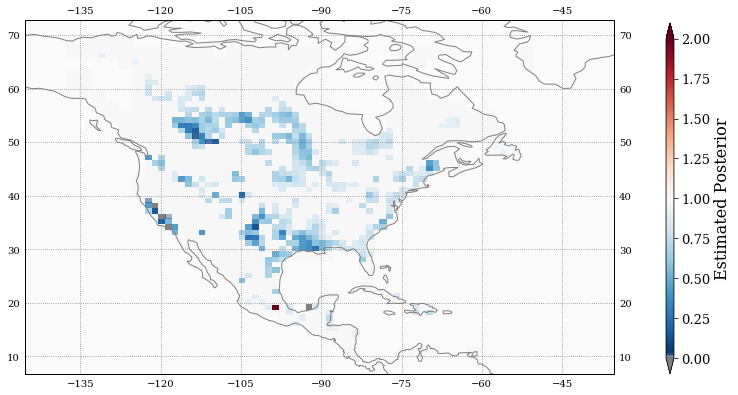

In [212]:
temp = xhats400[400].copy()
temp[np.diag(avker400400) == 0] = 1

fig, ax = plt.subplots(figsize=(11,6.5),
                           subplot_kw={'projection' : ccrs.PlateCarree()})
cax = fig.add_axes([0.95, 0.25/2, 0.01, 0.75])
plot_options = {'cmap' : inv_plot.cm_transparent_at_zero('RdBu_r'),
                'vmin' : 0,#-0.25,
                'vmax' : 2,#0.25,
#                 'add_colorbar' : False}
                'cbar_ax' : cax,
                'cbar_kwargs' : {'label' : 'Estimated Posterior - True Posterior'}}

inv_plot.plot_state(temp, clusters_1x125_r, ax, **plot_options)
cax.tick_params(labelsize=13)
cax.set_ylabel('Estimated Posterior', fontsize=16)

In [206]:
temp

array([1., 1., 1., ..., 1., 1., 1.])

Text(0.5,1,'Initial and Updated\nJacobian Estimates')

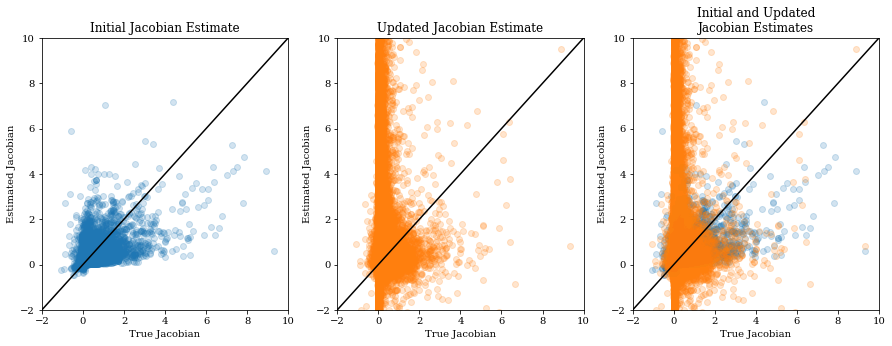

In [20]:
# We can check our results by plotting the regridded Jacobian against
# the true jacobian
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].scatter(k_true.values, k_rg.values, c='C0', alpha=0.2)
ax[1].scatter(k_true.values, k_1, c='C1', alpha=0.2)
ax[2].scatter(k_true.values, k_rg.values, c='C0', alpha=0.2)
ax[2].scatter(k_true.values, k_1, c='C1', alpha=0.2)

for axis in ax:
    axis.plot((-2,10), (-2,10), c='black')
    axis.set_ylim(-2,10)
    axis.set_xlim(-2,10)
    axis.set_ylabel('Estimated Jacobian')
    axis.set_xlabel('True Jacobian');
    
ax[0].set_title('Initial Jacobian Estimate')
ax[1].set_title('Updated Jacobian Estimate')
ax[2].set_title('Initial and Updated\nJacobian Estimates')

# Iterate

In [21]:
def iterate(k_prev, threshold=0.9, pert=0.5):
    # Start with a first iteration. Just for practice.
    pph_0 = inv_rr.calc_pph(k_prev, sa_vec.values, so_vec.values)
    evals, evecs = inv_rr.e_decomp(pph_0)

    # We want to determine how much information is contained in the 
    # current iteration. We will only use the eigenvectors that contain
    # most of the information content.

    # In order to do that, we calculate the eigenvalues of QDOF, which
    # are linearly related to the eigenvaleus of the prior pre-conditioned
    # Hessian.
    evals_pidof = evals * 1/(1 + evals)

    # Recall that QDOF is the averaging kernel weighted by the prior
    # error variance estimate. In the future, we will relate the eigenvalues
    # of QDOF to the eigenvalues of the averaging kernel. Then, Rodgers gives 
    # a relationship between the eigenvalues of the averaging kernel
    # and the eigenvalues of the prewhitened Jacobian. Those describe 
    # the signal to noise ratio. Until we prove that relationship, we will 
    # set a threshold for the information content that must be contained in 
    # the vectors we use.
    threshold_idx = np.argwhere(evals_pidof < (1-threshold)).min()
    print('Using %d eigenvectors.' % threshold_idx)
    
    # We then create the prolongation and reduction operators, based on 
    # the threshold found
    wk = evecs[:,:threshold_idx]
    reduct = (1/sa_vec**0.5).values * wk.T 
    prolong = (wk.T * (sa_vec**0.5).values).T
    project = prolong @ reduct
    
    # Calculate K_pi
    delta_y = np.zeros((delta_obs.shape[0], threshold_idx))
    for i in range(threshold_idx):
        delta_xa_i = pert * (prolong[:,i].reshape(-1,1) @ reduct[i,:].reshape(1,-1)) @ xa.values
        delta_y_i = k_true @ delta_xa_i
        delta_y[:,i] = delta_y_i

    k_red = delta_y/pert
    k_pi = k_red @ reduct
    
    # Finally, estimate the non-projected Jacobian
    k_next = k_prev @ (np.identity(project.shape[0]) - project) + k_pi
#     k_next = k_prev + (k_prev @ project) - k_pi
    
    print('')
    return k_next, evecs, evals_pidof


In [22]:
# Initialize a bunch of lists. These will store the stages of our iteration.
k = [k_rg]
eigenvecs = []
eigenvals = []

for i in range(10):
    kk, eevecs, eevals = iterate(k[i])
    k.append(kk)
    eigenvecs.append(eevecs)
    eigenvals.append(eevals)
    

Prior-preconditioned Hessian calculated (0.34 s)
Eigendecomposition complete (0.39 s)
Using 27 eigenvectors.

Prior-preconditioned Hessian calculated (0.29 s)
Eigendecomposition complete (0.39 s)
Using 25 eigenvectors.

Prior-preconditioned Hessian calculated (0.30 s)
Eigendecomposition complete (0.40 s)
Using 21 eigenvectors.

Prior-preconditioned Hessian calculated (0.29 s)
Eigendecomposition complete (0.38 s)
Using 18 eigenvectors.

Prior-preconditioned Hessian calculated (0.30 s)
Eigendecomposition complete (0.40 s)
Using 16 eigenvectors.

Prior-preconditioned Hessian calculated (0.30 s)
Eigendecomposition complete (0.39 s)
Using 14 eigenvectors.

Prior-preconditioned Hessian calculated (0.36 s)
Eigendecomposition complete (0.54 s)
Using 12 eigenvectors.

Prior-preconditioned Hessian calculated (0.34 s)
Eigendecomposition complete (0.40 s)
Using 9 eigenvectors.

Prior-preconditioned Hessian calculated (0.36 s)
Eigendecomposition complete (0.49 s)
Using 8 eigenvectors.

Prior-precon

In [23]:
# num_evs = [163, 125, 97, 79, 63, 49, 37, 29, 26, 23, 20, 17, 16, 15, 13, 8, 8, 7, 6, 4]
# fig, ax = plt.subplots(figsize=(10,5))
# ax.plot(np.arange(len(num_evs)), num_evs)
# ax.set_xlabel('Iteration Number')
# ax.set_ylabel('Number of Eigenvectors Used')

Text(0.5,0.98,'First Iteration')

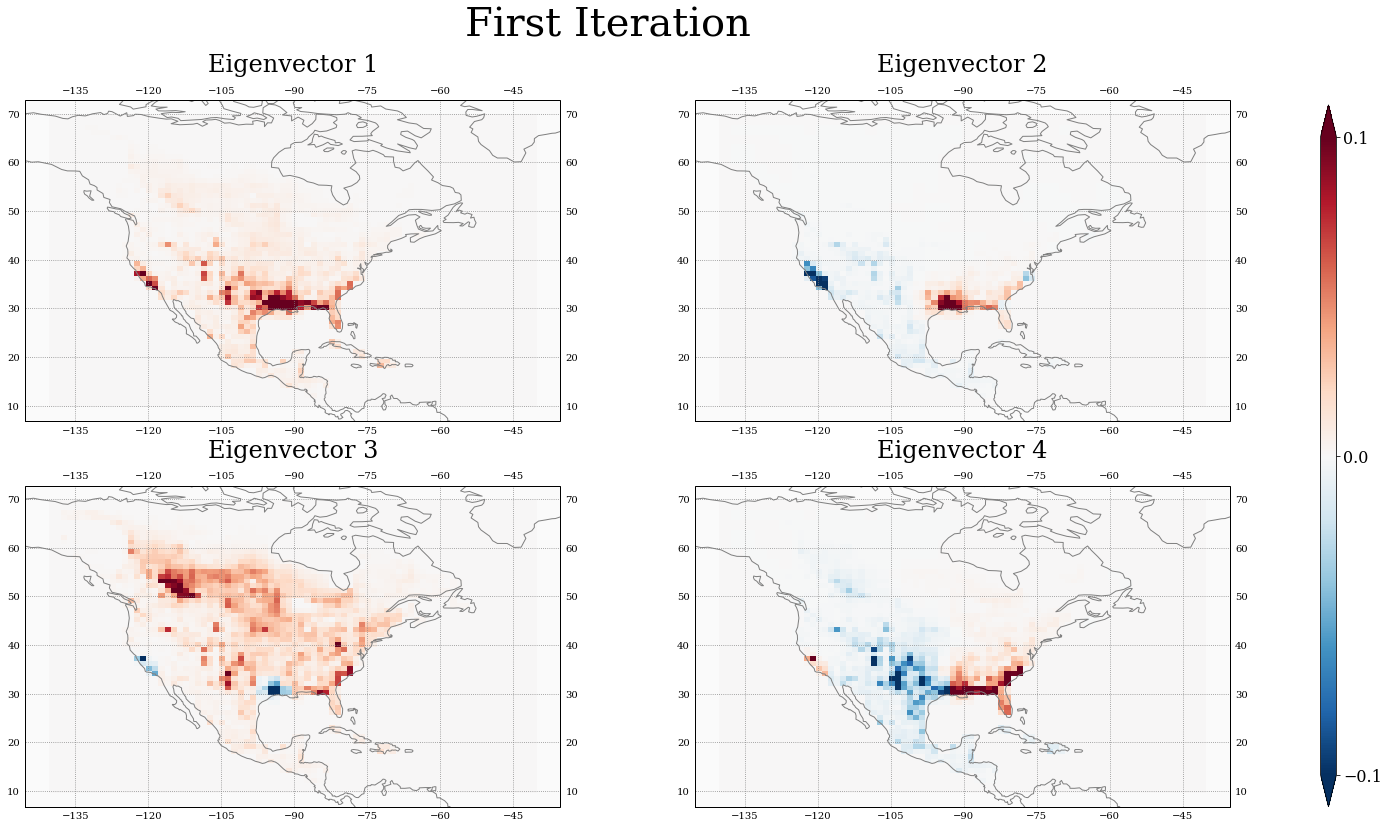

In [24]:
fig, ax = inv_plot.plot_evecs(eigenvecs[0], clusters_1x125_r)
plt.suptitle('First Iteration',
             fontsize=40)

In [25]:
# # # Check where evecs have the most value
# # # fig, ax = plt.subplots()
# # ax.hist(eigenvecs[0][:,0], 20)
# a = eigenvecs[0].copy()
# a[np.abs(a) < 0.025] = 0#.shape
# fig, ax = plot_evecs(a, clusters_1x125_r)
# plt.suptitle('Reduced',
#              fontsize=40)

In [26]:
# a = np.abs(a[:,:163]).sum(axis=1)
# plt.hist(a)
# # a.shape
# a[a > 1].shape

Text(0.5,0.98,'10th Iteration')

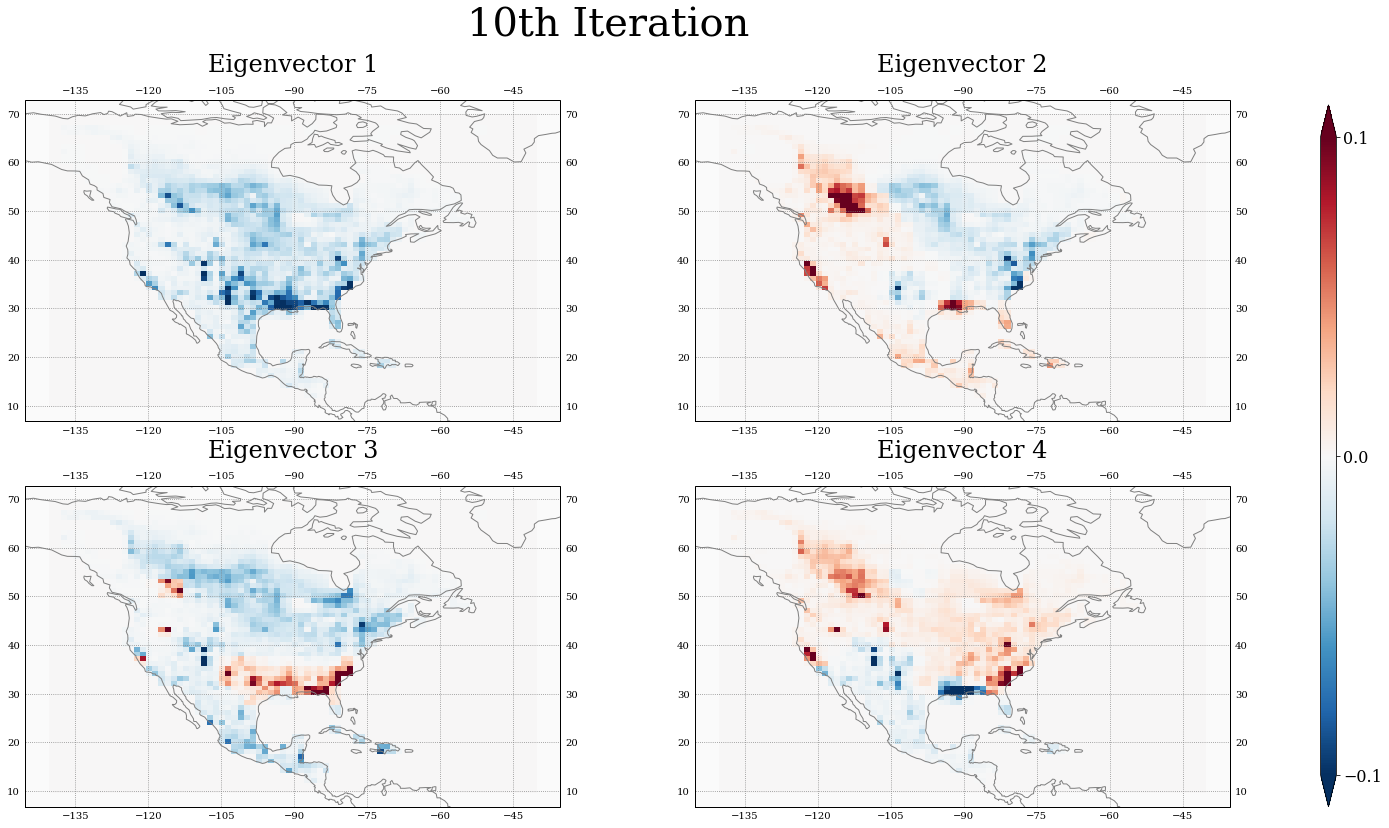

In [27]:
fig, ax = inv_plot.plot_evecs(eigenvecs[-1], clusters_1x125_r)
plt.suptitle('10th Iteration',
             fontsize=40)

Text(0.5,1,'Initial and Final\nJacobian Estimates')

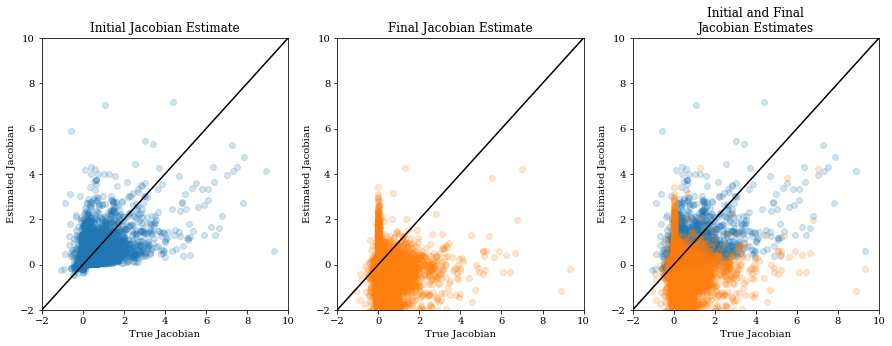

In [28]:
# We can check our results by plotting the regridded Jacobian against
# the true jacobian
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].scatter(k_true.values, k[0].values, c='C0', alpha=0.2)
ax[1].scatter(k_true.values, k[-1], c='C1', alpha=0.2)
ax[2].scatter(k_true.values, k[0].values, c='C0', alpha=0.2)
ax[2].scatter(k_true.values, k[-1], c='C1', alpha=0.2)

for axis in ax:
    axis.plot((-2,10), (-2,10), c='black')
    axis.set_ylim(-2,10)
    axis.set_xlim(-2,10)
    axis.set_ylabel('Estimated Jacobian')
    axis.set_xlabel('True Jacobian');
    
ax[0].set_title('Initial Jacobian Estimate')
ax[1].set_title('Final Jacobian Estimate')
ax[2].set_title('Initial and Final\nJacobian Estimates')

In [29]:
# # TO RESOLVE
# # Calculate averaging kernel of the true Jacobian, first Jacobian, and final Jacobian
# sa_sqrt = sparse.diags(sa_vec.values**0.5)
# sa_sqrt_inv = sparse.diags(1/sa_vec.values**0.5)

# a_p_0 = sa_sqrt @ inv_rr.a_p_sum(1736, eigenvals[0], eigenvecs[0]) @ sa_sqrt_inv
# a_p_last = sa_sqrt @ inv_rr.a_p_sum(1736, eigenvals[-1], eigenvecs[-1]) @ sa_sqrt_inv
# a_p_true = a_p_0 = sa_sqrt @ inv_rr.a_p_sum(1736, evals_true, evecs_true) @ sa_sqrt_inv


In [30]:
# (a_p_true - a_p_0).sum()

In [31]:
def calc_avker(k, sa_v, so_v):
    sa = sparse.diags(sa_v.values)
    so = sparse.diags(so_v.values)
    avker = sa @ k.T @ np.linalg.inv(k @ sa @ k.T + so) @ k
    return avker

a_p_0_2 = calc_avker(k[0], sa_vec, so_vec)
a_p_last_2 = calc_avker(k[-1], sa_vec, so_vec)
a_p_true_2 = calc_avker(k_true.values, sa_vec, so_vec)

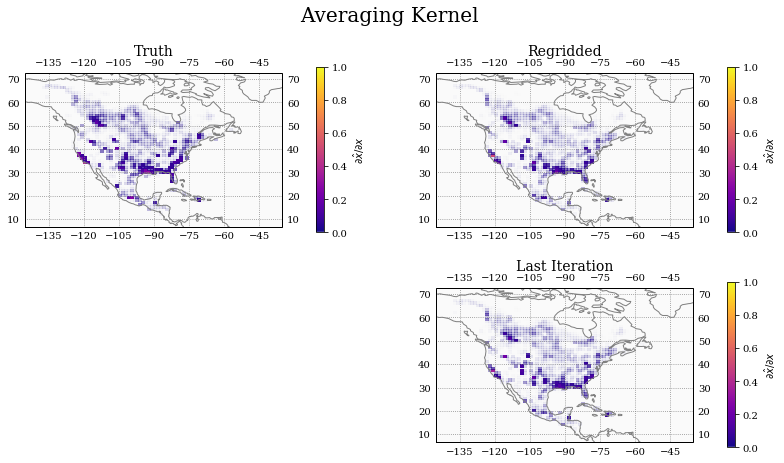

In [32]:
pos_rr = {'cmap' : inv_plot.cm_transparent_at_zero('plasma'),
          'vmin' : 0, 'vmax' : 1,
          'cbar_kwargs' : {'label' : '$\partial{\hat{x}}/\partial{x}$',
                           'pad' : 0.1}}

fig, ax = plt.subplots(2,2,figsize=(13.5,7),subplot_kw={'projection' : ccrs.PlateCarree()})
plt.subplots_adjust(hspace=0.3)
plt.suptitle('Averaging Kernel', fontsize=20, y=1, ha='center')
ax[0,0] = inv_plot.plot_state(np.diag(a_p_true_2), clusters_1x125_r, ax[0,0], **pos_rr)
ax[0,0].set_title('Truth', fontsize=14, y=1.075)

ax[0,1] = inv_plot.plot_state(np.diag(a_p_0_2), clusters_1x125_r, ax[0,1], **pos_rr)
ax[0,1].set_title('Regridded', fontsize=14, y=1.075)

ax[1,1] = inv_plot.plot_state(np.diag(a_p_last_2), clusters_1x125_r, ax[1,1], **pos_rr)
ax[1,1].set_title('Last Iteration', fontsize=14, y=1.075)

ax[1,0].remove()

In [33]:
np.trace(a_p_true_2)

16.296192409102744

# Inversion Test

## Truth

In [32]:
def obs_mod_diff(x, y, k, c):
    return np.asarray(y - (k @ x + c))

def cost(x, xa, so_inv, sa_inv, diff_func=obs_mod_diff):
    obso = diff_func(x)
    cost_obs = obso.T @ so_inv @ obso
    cost_emi = (x - xa).T @ sa_inv @ (x - xa)
    return cost_obs + cost_emi

In [56]:
# for i, factor in enumerate([0.1, 0.5, 1.0, 1.5, 10, 15]):
#     sa_inv = sparse.diags(1/sa_vec.values)
#     so_inv = sparse.diags(1/(factor*so_vec.values))

#     k_inst = k_true

#     c_true = y_base.values - k_inst @ xa.values

#     obs_mod_diff_func = lambda x: obs_mod_diff(x, y=y, k=k_inst.values, c=c_true)
#     cost_func = lambda x: cost(x, 
#                                xa=xa, 
#                                so_inv=so_inv, 
#                                sa_inv=sa_inv,
#                                diff_func=obs_mod_diff_func)

#     shat_true = np.linalg.inv(k_inst.T @ so_inv @ k_inst + sa_inv)
#     g_true = shat_true @ k_inst.T @ so_inv
#     xhat_true = np.asarray(xa.values + (g_true @ (y.values - (k_inst @ xa.values + c_true)))).reshape(-1)

#     cost_prior = cost_func(xa.values)
#     cost_post = cost_func(xhat_true)
#     pct_dec = (cost_post - cost_prior)/cost_prior
    
#     print('Factor = %.2f: %.2f' % (factor, pct_dec))

In [57]:
# Use 0.05. This is consistent with the value used in previous inversions.
sa_inv = sparse.diags(1/sa_vec.values)
so_inv = 0.05*sparse.diags(1/so_vec.values)

k_inst = k_true

c_true = y_base.values - k_inst @ xa.values

obs_mod_diff_func = lambda x: obs_mod_diff(x, y=y, k=k_inst.values, c=c_true)
cost_func = lambda x: cost(x, 
                           xa=xa, 
                           so_inv=so_inv, 
                           sa_inv=sa_inv,
                           diff_func=obs_mod_diff_func)

shat_true = np.linalg.inv(k_inst.T @ so_inv @ k_inst + sa_inv)
g_true = shat_true @ k_inst.T @ so_inv
xhat_true = np.asarray(xa.values + (g_true @ (y.values - (k_inst @ xa.values + c_true)))).reshape(-1)

In [58]:
xhat_true.max()

1.0000359882823553

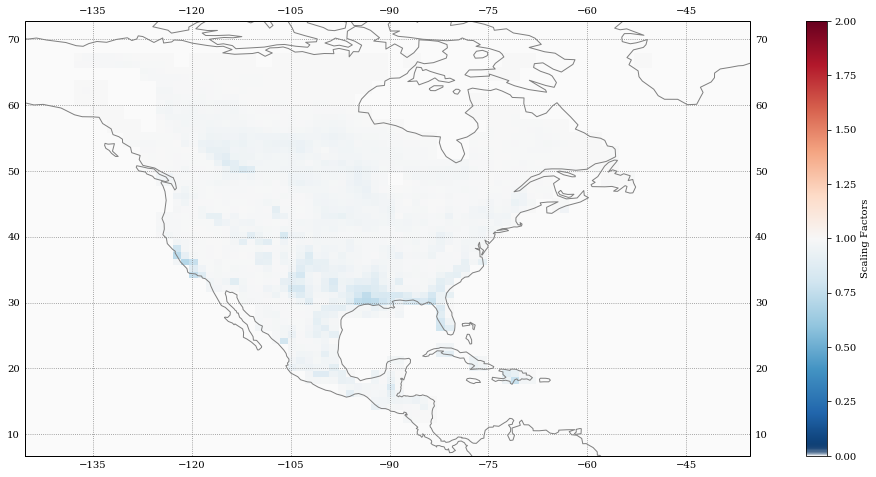

In [59]:
plot_options_state_rel = {'cmap' : inv_plot.cm_transparent_at_zero('RdBu_r'),
                          'vmin' : 0,
                          'vmax' : 2,
                          'cbar_kwargs' : {'label' : 'Scaling Factors'}}

inv_plot.plot_state(xhat_true, clusters_1x125_r, **plot_options_state_rel)

## Iterated Estimate

In [37]:
k_inst = k[-1]
c_it = y_base.values - k_inst @ xa.values
shat_it = np.linalg.inv(k_inst.T @ so_inv @ k_inst + sa_inv)
g_it = shat_it @ k_inst.T @ so_inv
xhat_it = np.asarray(xa.values + (g_it @ (y.values - (k_inst @ xa.values + c_it))))

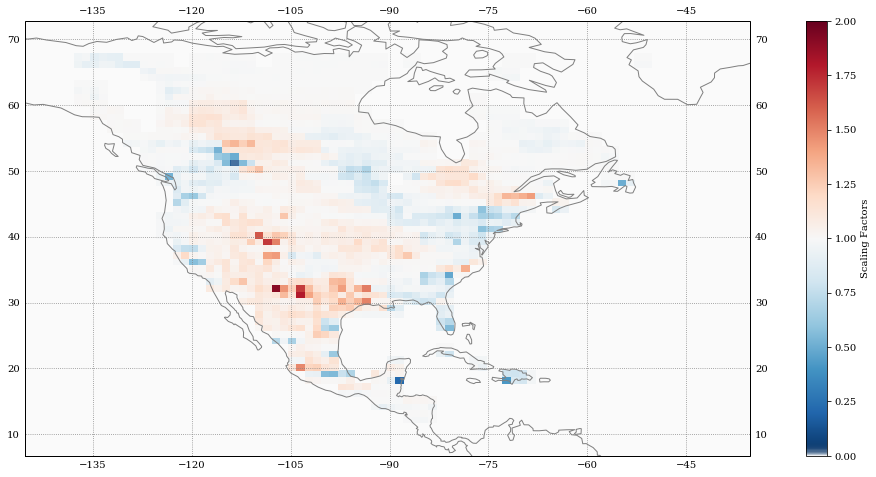

In [38]:
plot_options_state_rel = {'cmap' : inv_plot.cm_transparent_at_zero('RdBu_r'),
                          'vmin' : 0,
                          'vmax' : 2,
                          'cbar_kwargs' : {'label' : 'Scaling Factors'}}

inv_plot.plot_state(xhat_it, clusters_1x125_r, **plot_options_state_rel)

## Projected Jacobian (k_pi_0)

In [39]:
k_inst = k_pi_0
c_proj = y_base.values - k_inst @ xa.values
shat_proj = np.linalg.inv(k_inst.T @ so_inv @ k_inst + sa_inv)
g_proj = shat_proj @ k_inst.T @ so_inv
xhat_proj = np.asarray(xa.values + (g_proj @ (y.values - (k_inst @ xa.values + c_proj))))

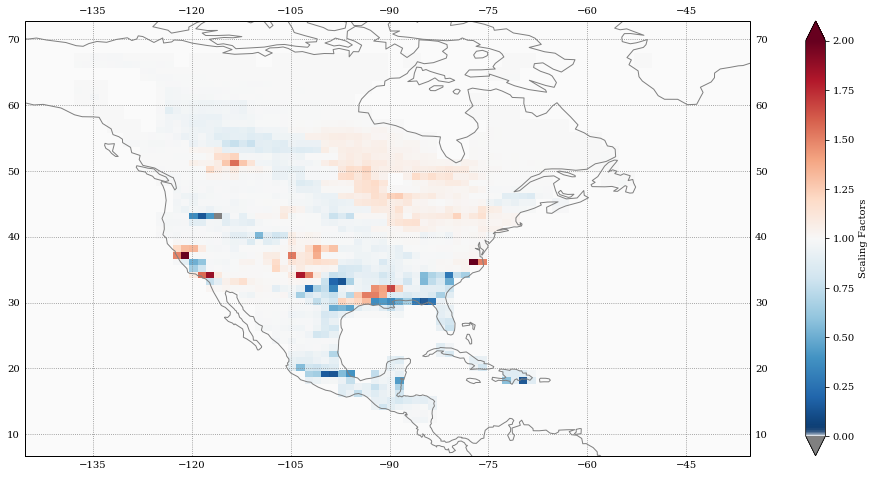

In [40]:
plot_options_state_rel = {'cmap' : inv_plot.cm_transparent_at_zero('RdBu_r'),
                          'vmin' : 0,
                          'vmax' : 2,
                          'cbar_kwargs' : {'label' : 'Scaling Factors'}}

inv_plot.plot_state(xhat_proj, clusters_1x125_r, **plot_options_state_rel)

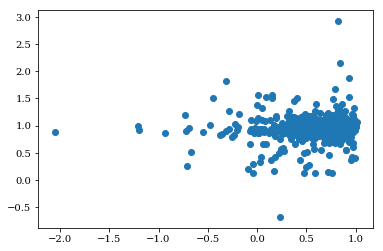

In [41]:
plt.scatter(xhat_true, xhat_proj)

# Perturbing Individual Elements in Eigenvectors

In [196]:
# Calculate DOFS
a_1 = calc_avker(k_rg, sa_vec, so_vec)
a_true = calc_avker(k_true, sa_vec, so_vec)
dofs_1 = np.trace(a_1)
print('DOFS = %.2f' % dofs_1)

DOFS = 10.96


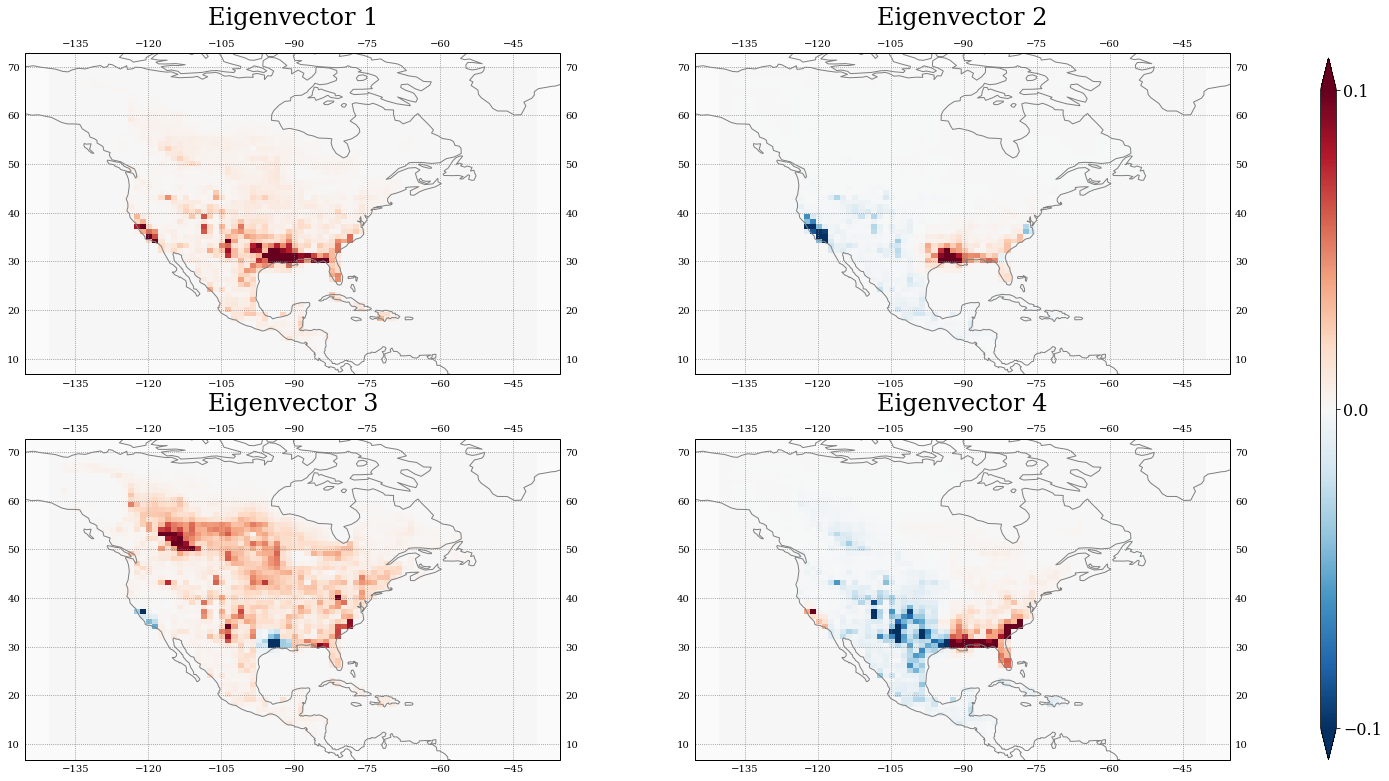

In [36]:
fig, ax = inv_plot.plot_evecs(eigenvecs[0], clusters_1x125_r)
# plt.suptitle('Eigenvectors ',
#              fontsize=40)

Text(0.5,1.05,'Averaging Kernel (DOFS = 10.96)')

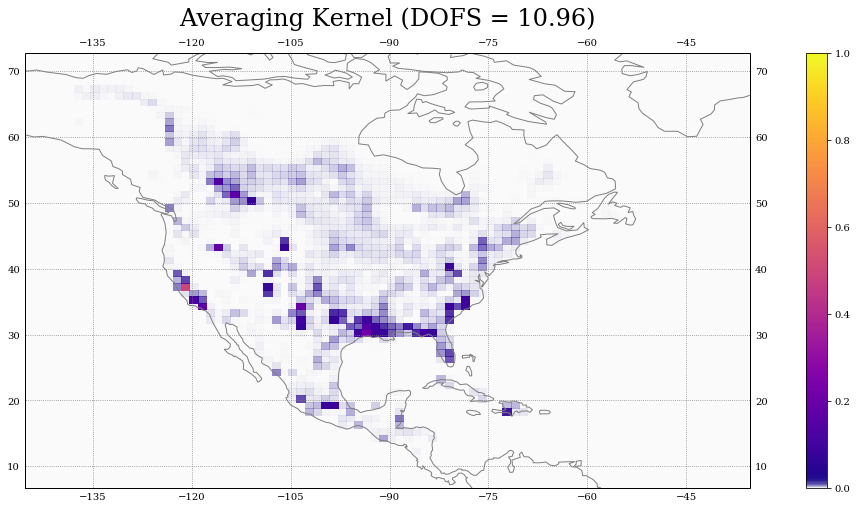

In [45]:
plot_options_avker = {'cmap' : inv_plot.cm_transparent_at_zero('plasma'),
                      'vmin' : 0,
                      'vmax' : 1,
                      'add_colorbar' : True}

ax = inv_plot.plot_state(np.diag(a_1), 
                         clusters=clusters_1x125_r,
                         **plot_options_avker)
ax.set_title('Averaging Kernel (DOFS = %.2f)' % dofs_1, fontsize=24, y=1.05)
# print('Grid Cells : %d' % len(sum_evecs[sum_evecs > 0]))

Text(0.5,1.05,'Sum of First 11 Eigenvectors (Absolute)\nThreshold: 0.0, Non-zero grid cells: 516/1736')

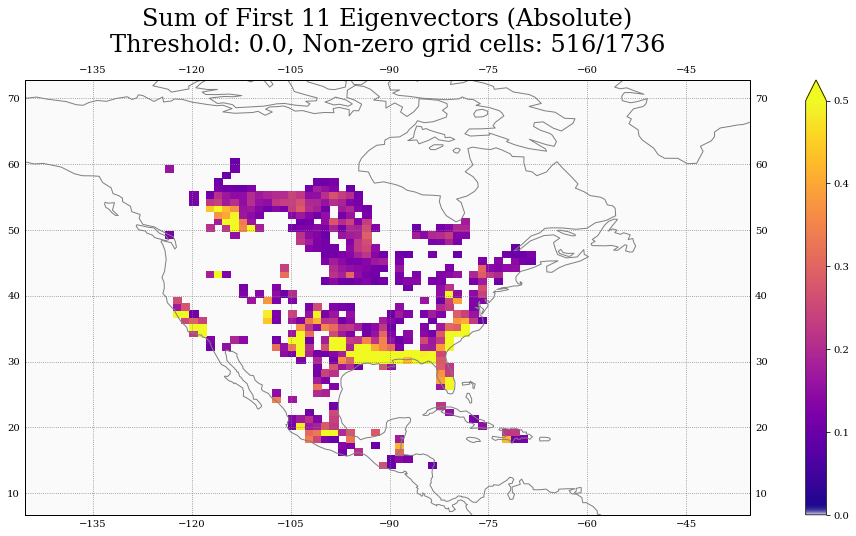

In [64]:
plot_options_evecs = {'cmap' : inv_plot.cm_transparent_at_zero('plasma'),
                      'vmin' : 0,
                      'vmax' : 0.5,
                      'add_colorbar' : True}

sum_evecs = np.abs(eigenvecs[0][:,:11]).sum(axis=1)
sum_evecs[sum_evecs < 0.1] = 0
ax = inv_plot.plot_state(sum_evecs, 
                         clusters=clusters_1x125_r,
                         **plot_options_evecs)
ax.set_title('Sum of First %d Eigenvectors (Absolute)\nThreshold: 0.0, Non-zero grid cells: %d/1736' 
             % (np.round(dofs_1), len(sum_evecs[sum_evecs > 0])),
             fontsize=24,
             y=1.05)
# print('Grid Cells : %d' % len(sum_evecs[sum_evecs > 0]))


(0, 0.5)

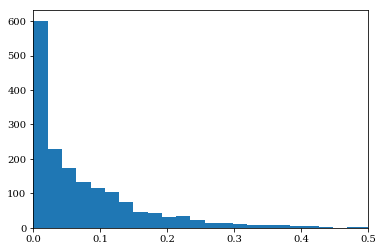

In [51]:
plt.hist(sum_evecs,100);
plt.xlim(0,0.5)

In [36]:
# threshold_idx = np.argwhere(evals_pidof < (1-0.8)).min()
# print('Using %d eigenvectors.' % threshold_idx)

# temp = np.abs(eigenvecs[0][:,:threshold_idx]).sum(axis=1)

# plot_options_evecs = {'cmap' : inv_plot.cm_transparent_at_zero('plasma'),
#                       'vmin' : 0,
#                       'vmax' : 1,
#                       'add_colorbar' : True}
# inv_plot.plot_state(temp, 
#                     clusters=clusters_1x125_r,
#                     **plot_options_evecs)

In [37]:
# temp[temp < 0.1] = 0
# print('Number of non-zero elements = %d' % len(temp[temp > 0]))
# inv_plot.plot_state(temp, 
#                     clusters=clusters_1x125_r,
#                     **plot_options_evecs)

In [65]:
k_test = k_rg.copy()
for i, value in enumerate(sum_evecs):
    if value != 0:
        xa_temp = np.zeros(len(np.unique(clusters_1x125_s)[1:]))
        xa_temp[i] = 0.5
        delta_y = k_true @ xa_temp
        k_test[:,i] = delta_y/0.5

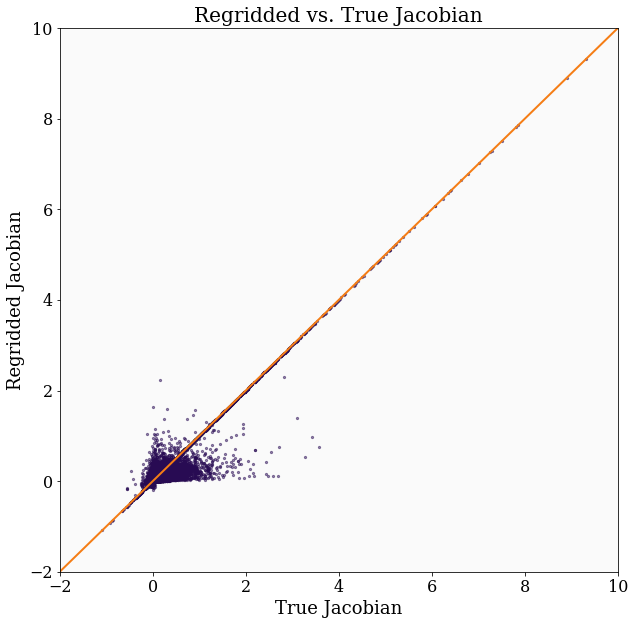

In [66]:
# # We can check our results by plotting the regridded Jacobian against
# # the true jacobian
# fig, ax = plt.subplots(1,1,figsize=(5,5))
# # ax[0].scatter(k_true.values, k_rg.values, c='C0', alpha=0.2)
# ax.scatter(k_true.values, k_test, c='C1', alpha=0.2)
# # ax[2].scatter(k_true.values, k_rg.values, c='C0', alpha=0.2)
# # ax[2].scatter(k_true.values, k_test, c='C1', alpha=0.2)

# # for axis in ax:
# #     axis.plot((-2,10), (-2,10), c='black')
# #     axis.set_ylim(-2,10)
# #     axis.set_xlim(-2,10)
# #     axis.set_ylabel('Estimated Jacobian')
# #     axis.set_xlabel('True Jacobian');
    
# # ax[0].set_title('Initial Jacobian Estimate')
# # ax[1].set_title('Updated Jacobian Estimate')
# # ax[2].set_title('Initial and Updated\nJacobian Estimates')

# We can check our results by plotting the regridded Jacobian against
# the true jacobian
# THING ABOUT WHETHER OR NOT THIS MAKES SENSE
fig, ax = plt.subplots(figsize=(10,10))
ax.set_facecolor('0.98')
ax.scatter(k_true.values, k_test, alpha=0.5, s=5, c=colors(1))
ax.set_ylim(-2,10)
ax.set_xlim(-2,10)
ax.plot((-2,10), (-2,10), c=colors(5), lw=2)
ax.set_xlabel('True Jacobian', fontsize=18)
ax.set_ylabel('Regridded Jacobian', fontsize=18)
ax.set_title('Regridded vs. True Jacobian', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16);

In [ ]:
# Test the inversion results

In [67]:
# Use 0.05. This is consistent with the value used in previous inversions.
sa_inv = sparse.diags(1/sa_vec.values)
so_inv = 0.05*sparse.diags(1/so_vec.values)

k_inst = k_true

c_true = y_base.values - k_inst @ xa.values

obs_mod_diff_func = lambda x: obs_mod_diff(x, y=y, k=k_inst.values, c=c_true)
cost_func = lambda x: cost(x, 
                           xa=xa, 
                           so_inv=so_inv, 
                           sa_inv=sa_inv,
                           diff_func=obs_mod_diff_func)

shat_true = np.linalg.inv(k_inst.T @ so_inv @ k_inst + sa_inv)
g_true = shat_true @ k_inst.T @ so_inv
xhat_true = np.asarray(xa.values + (g_true @ (y.values - (k_inst @ xa.values + c_true)))).reshape(-1)

k_inst = k_rg

c_rg = y_base.values - k_inst @ xa.values

obs_mod_diff_func = lambda x: obs_mod_diff(x, y=y, k=k_inst.values, c=c_rg)
cost_func = lambda x: cost(x, 
                           xa=xa, 
                           so_inv=so_inv, 
                           sa_inv=sa_inv,
                           diff_func=obs_mod_diff_func)

shat_rg = np.linalg.inv(k_inst.T @ so_inv @ k_inst + sa_inv)
g_rg = shat_rg @ k_inst.T @ so_inv
xhat_rg = np.asarray(xa.values + (g_rg @ (y.values - (k_inst @ xa.values + c_rg)))).reshape(-1)



k_inst = k_test

c_test = y_base.values - k_inst @ xa.values

obs_mod_diff_func = lambda x: obs_mod_diff(x, y=y, k=k_inst.values, c=c_test)
cost_func = lambda x: cost(x, 
                           xa=xa, 
                           so_inv=so_inv, 
                           sa_inv=sa_inv,
                           diff_func=obs_mod_diff_func)

shat_test = np.linalg.inv(k_inst.T @ so_inv @ k_inst + sa_inv)
g_test = shat_test @ k_inst.T @ so_inv
xhat_test = np.asarray(xa.values + (g_test @ (y.values - (k_inst @ xa.values + c_test)))).reshape(-1)

Text(0.5,1.07,'Updated Jacobian - True Jacobian')

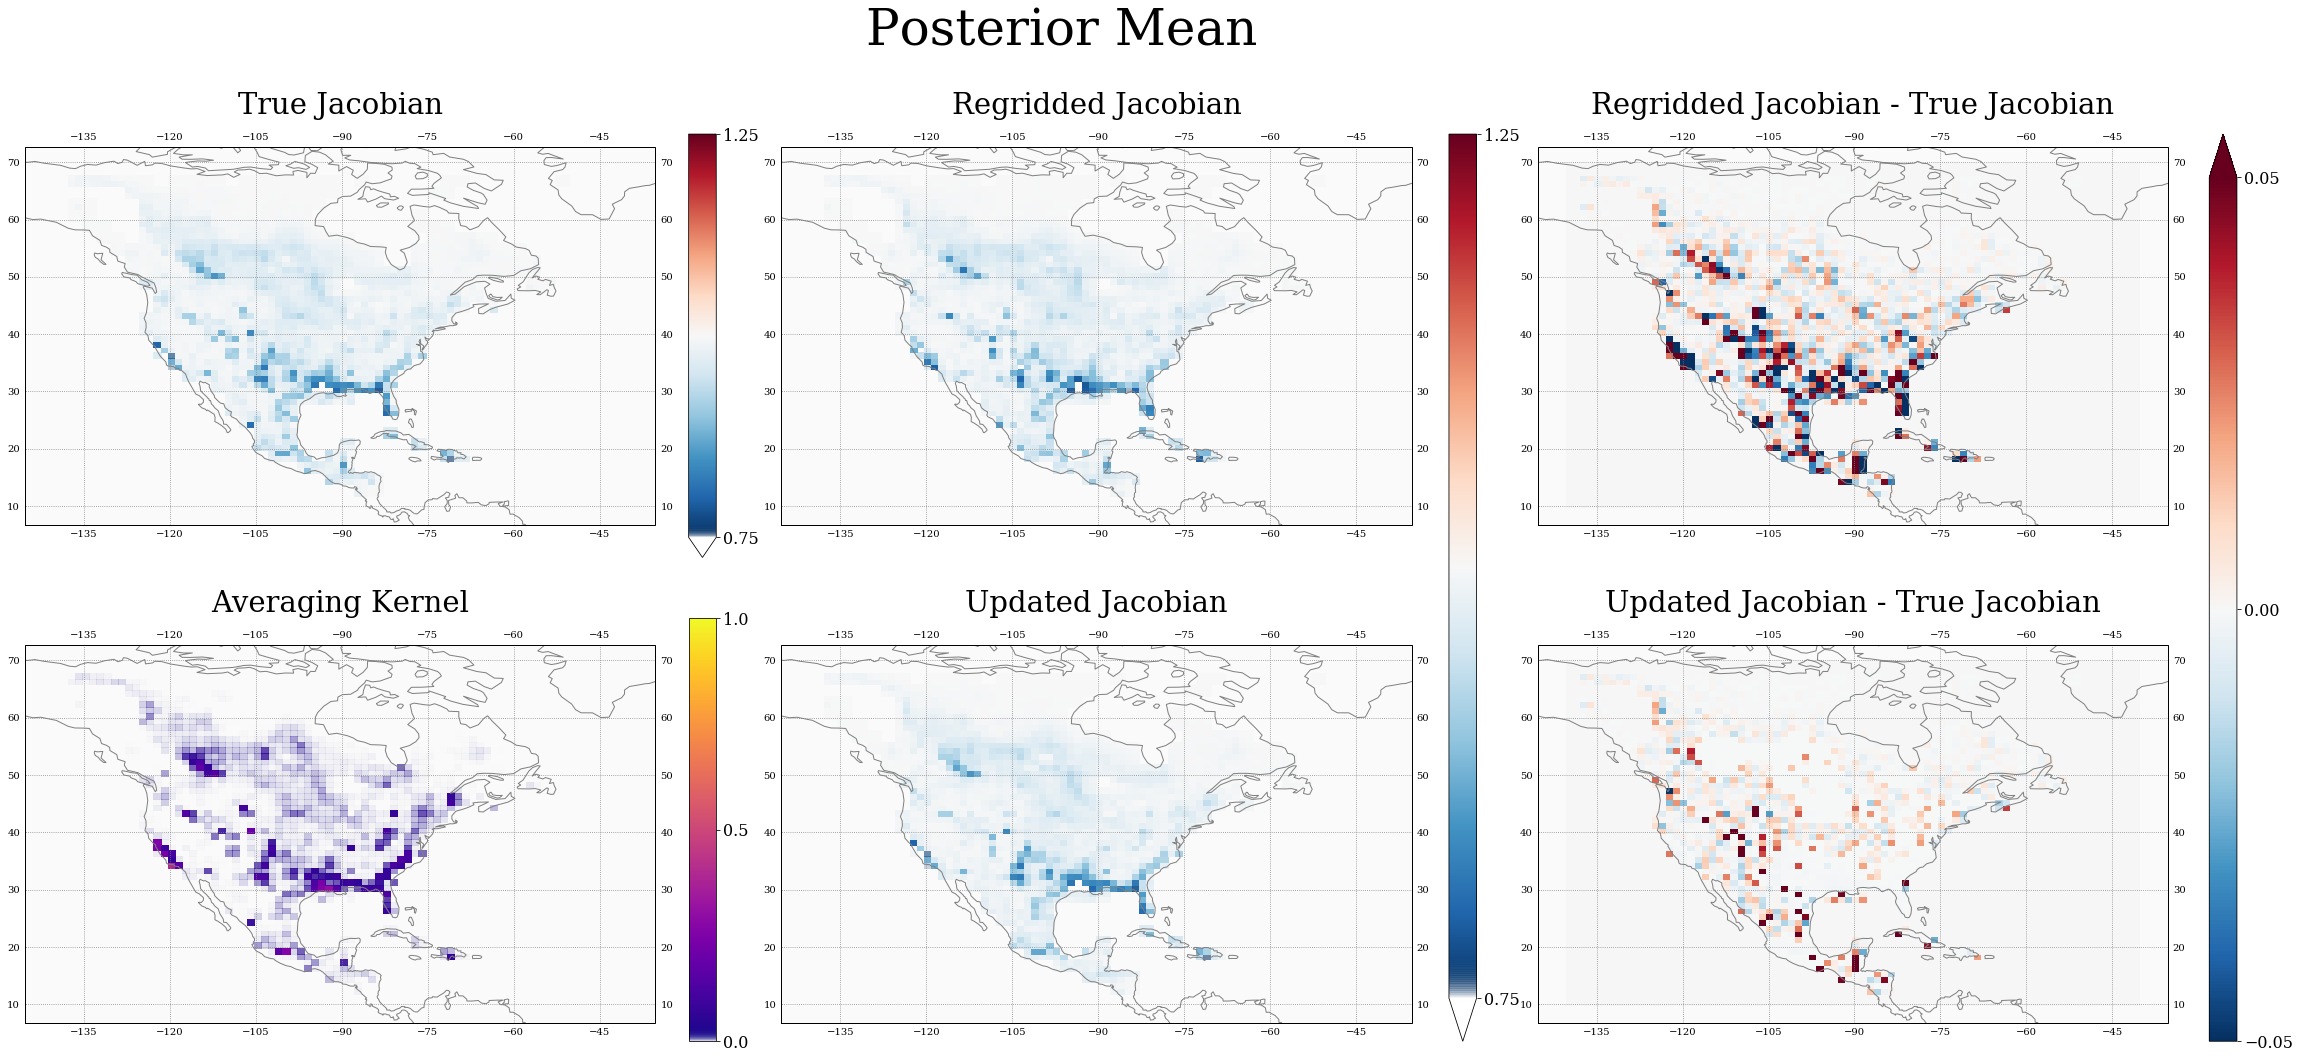

In [201]:
my_cmap = plt.cm.get_cmap('RdBu_r',lut=3000)
my_cmap._init()
slopen = 200
alphas_slope = np.abs(np.linspace(0, 1.0, slopen))
alphas_stable = np.ones(3003-slopen)
alphas = np.concatenate((alphas_slope, alphas_stable))
my_cmap._lut[:,-1] = alphas
my_cmap.set_under('0.98', alpha=0)

plot_options_post = {'cmap' : my_cmap,
                     'vmin' : 0.75,
                     'vmax' : 1.25,
                     'add_colorbar' : False}

fig, ax = plt.subplots(2,3,figsize=(2*3*8/1.25,2*10.5/1.25),
                       subplot_kw={'projection': ccrs.PlateCarree()})
cax_avker = fig.add_axes([0.365, 0.25/2, 0.01, 1-0.525-0.25/2])
cax0 = fig.add_axes([0.365, 0.525, 0.01, 1-0.525-0.25/2])
cax1 = fig.add_axes([0.64, 0.25/2, 0.01, 0.75])
cax2 = fig.add_axes([0.915, 0.25/2, 0.01, 0.75])
plt.suptitle('Posterior Mean', fontsize=50, y=0.98)

plot_options_avker = {'cmap' : inv_plot.cm_transparent_at_zero('plasma'),
                      'vmin' : 0,
                      'vmax' : 1,
                      'cbar_ax' : cax_avker,
                      'cbar_kwargs' : {'ticks' : [0,0.5,1]}}
inv_plot.plot_state(np.diag(a_true), clusters_1x125_r, ax=ax[1,0], **plot_options_avker)
cax_avker.tick_params(labelsize=16)

inv_plot.plot_state(xhat_rg, clusters_1x125_r, ax=ax[0,1], **plot_options_post)

del(plot_options_post['add_colorbar'])
plot_options_post['cbar_ax'] = cax1
plot_options_post['cbar_kwargs'] = {'ticks': [plot_options_post['vmin'], 
                                              0, 
                                              plot_options_post['vmax']]}
cax1.tick_params(labelsize=16)

inv_plot.plot_state(xhat_test, clusters_1x125_r, 
                    ax=ax[1,1], **plot_options_post)

plot_options_post['cbar_ax'] = cax0
plot_options_post['cbar_kwargs'] = {'ticks': [plot_options_post['vmin'], 
                                              0, 
                                              plot_options_post['vmax']]}
cax0.tick_params(labelsize=16)
inv_plot.plot_state(xhat_true, clusters_1x125_r, ax=ax[0,0], **plot_options_post)


# Plot differences
plot_options_post_diff = {'cmap' : 'RdBu_r',
                          'vmin' : -0.05,
                          'vmax' : 0.05,
                          'add_colorbar' : False}

inv_plot.plot_state(xhat_rg-xhat_true, clusters_1x125_r, 
                    ax=ax[0,2], **plot_options_post_diff)

del(plot_options_post_diff['add_colorbar'])
plot_options_post_diff['cbar_ax'] = cax2
plot_options_post_diff['cbar_kwargs'] = {'ticks': [plot_options_post_diff['vmin'], 
                                                   0, 
                                                   plot_options_post_diff['vmax']]}
cax2.tick_params(labelsize=16)

inv_plot.plot_state(xhat_test-xhat_true, clusters_1x125_r, 
                    ax=ax[1,2], **plot_options_post_diff)

# ax[1,0].remove()
ax[0,0].set_title('True Jacobian', y=1.07, fontsize=29)
ax[1,0].set_title('Averaging Kernel', y=1.07, fontsize=29)
ax[0,1].set_title('Regridded Jacobian', y=1.07, fontsize=29)
ax[1,1].set_title('Updated Jacobian', y=1.07, fontsize=29)
ax[0,2].set_title('Regridded Jacobian - True Jacobian', y=1.07, fontsize=29)
ax[1,2].set_title('Updated Jacobian - True Jacobian', y=1.07, fontsize=29)

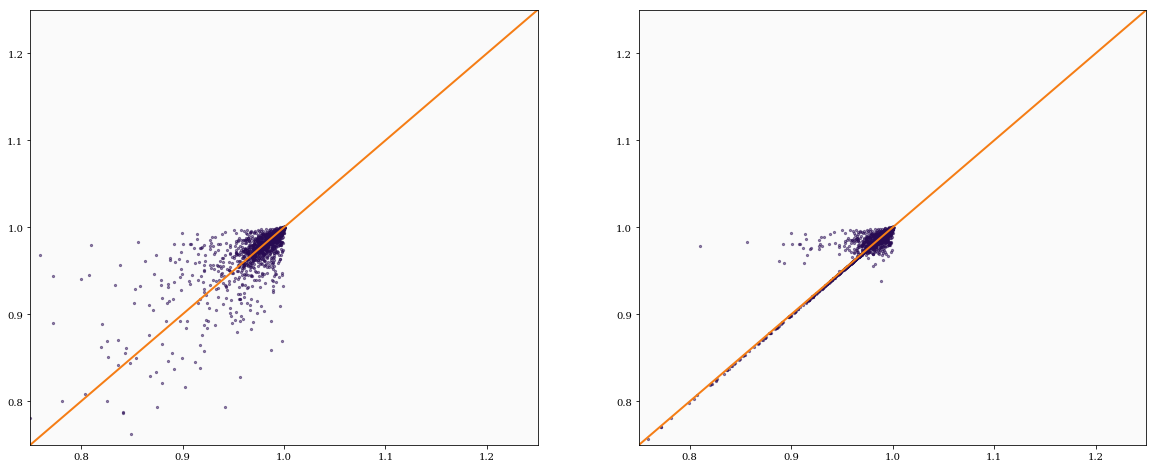

In [129]:
fig, ax = plt.subplots(1,2,figsize=(20,8))

ax[0].scatter(xhat_true, xhat_rg, alpha=0.5, s=5, c=colors(1))
ax[1].scatter(xhat_true, xhat_test, alpha=0.5, s=5, c=colors(1))
# ax.scatter(k_true.values, k_test, alpha=0.5, s=5, c=colors(1))

for axis in ax.flatten():
    axis.set_facecolor('0.98')
    axis.set_ylim(0.75,1.25)
    axis.set_xlim(0.75,1.25)
    axis.plot((0.75,1.25), (0.75,1.25), c=colors(5), lw=2)
# ax.set_xlabel('True Jacobian', fontsize=18)
# ax.set_ylabel('Regridded Jacobian', fontsize=18)
# ax.set_title('Regridded vs. True Jacobian', fontsize=20)
# plt.tick_params(axis='both', which='major', labelsize=16);

---
Scratch

In [ ]:
obs_base = pd.read_csv('Perturbation_Runs/sat_obs_files/sat_obs.gosat.00.0000.m', 
                       delim_whitespace=True,
                       header=0)
obs_base['S_OBS'] = np.sqrt(obs_base['S_OBS'])*1e9
obs_base['GOSAT'] = obs_base['GOSAT']*1e9
obs_base['model'] = obs_base['model']*1e9
obs_base['diff'] = obs_base['model'] - obs_base['GOSAT']

obs_pert = pd.read_csv('Perturbation_Runs/sat_obs_files/sat_obs.gosat.00.0150.m', 
                       delim_whitespace=True,
                       header=0)
obs_pert['S_OBS'] = np.sqrt(obs_pert['S_OBS'])*1e9
obs_pert['GOSAT'] = obs_pert['GOSAT']*1e9
obs_pert['model'] = obs_pert['model']*1e9
obs_pert['diff'] = obs_pert['model'] - obs_pert['GOSAT']

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,4.5),
                       subplot_kw={'projection' : ccrs.PlateCarree()})

cmap=['plasma']
vlims = [(1650, 1950)]

# df1 = obs_base[(obs_base['MM'] == 7)] 
# df2 = obs_pert[obs_pert['MM'] == 7]
df = delta_obs[:,460]
coordinates = obs_base[obs_base['NNN'].isin(delta_obs.coords['Nobs'])]

# ax.set_title('GOSAT Observations (July 2009)', fontsize=18) 
im = ax.scatter(coordinates['LON'], coordinates['LAT'], 
                c=df, 
                cmap=inv_plot.cm_transparent_at_zero('Reds'),
#                 cmap=cmap[0],
#                 vmin=vlims[0][0], vmax=vlims[0][1],
                vmin=0, vmax=0.1,
                s=1.5)

cb = fig.colorbar(im, ax=ax)
cb.set_label('XCH4 (ppb)', fontsize=12)

ax.set_xlim(-140,-40)
ax.set_ylim(10,70)
ax.add_feature(cartopy.feature.OCEAN, facecolor='0.98')
ax.add_feature(cartopy.feature.LAND, facecolor='0.98')
ax.coastlines(color='grey')
ax.gridlines(linestyle=':', draw_labels=True, color='grey')

In [ ]:
delta_obs[:,460]

In [ ]:
df

In [ ]:
obs_base[obs_base['NNN'].isin(delta_obs.coords['Nobs'])]

In [210]:
reduct_true[:,4].reshape(-1,1) @ prolong_true[4,:].reshape(-1,1).T


array([[ 2.70252821e-06, -2.88999606e-06,  2.49675256e-06, ...,
        -1.25476994e-16,  2.08660459e-16,  5.63692560e-16],
       [-2.88999606e-06,  3.09046810e-06, -2.66994625e-06, ...,
         1.34181029e-16, -2.23134731e-16, -6.02794550e-16],
       [ 2.49675256e-06, -2.66994625e-06,  2.30664506e-06, ...,
        -1.15922936e-16,  1.92772654e-16,  5.20771933e-16],
       ...,
       [-1.25476994e-16,  1.34181029e-16, -1.15922936e-16, ...,
         5.82583222e-27, -9.68799769e-27, -2.61719554e-26],
       [ 2.08660459e-16, -2.23134731e-16,  1.92772654e-16, ...,
        -9.68799769e-27,  1.61105394e-26,  4.35223387e-26],
       [ 5.63692560e-16, -6.02794550e-16,  5.20771933e-16, ...,
        -2.61719554e-26,  4.35223387e-26,  1.17574833e-25]])